In [1]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv(r"/drive/My Drive/2022 Fall NJBDA Externship Project/Colab Notebooks/Daily_Max_Vals.txt")

In [4]:
df

,Unnamed: 0,date,stid,gauge,discharge,rainfall_inches,rainfall_ft
0,0,2007-10-01,RA101,2.40,23.9,0.0,0.0
1,1,2007-10-02,RA101,2.39,23.2,0.0,0.0
2,2,2007-10-03,RA101,2.39,23.2,0.0,0.0
3,3,2007-10-04,RA101,2.39,23.2,0.0,0.0
4,4,2007-10-05,RA101,2.42,25.2,0.0,0.0
...,...,...,...,...,...,...,...
5472,5472,2022-10-18,RA101,3.35,153.0,0.0,0.0
5473,5473,2022-10-19,RA101,2.92,77.7,0.0,0.0
5474,5474,2022-10-20,RA101,2.85,68.1,0.0,0.0
5475,5475,2022-10-21,RA101,2.77,57.9,0.0,0.0


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from datetime import date

from itertools import product

np.random.seed(0)
sns.set()

In [6]:
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477 entries, 0 to 5476
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             5477 non-null   datetime64[ns]
 1   stid             5477 non-null   object        
 2   gauge            5477 non-null   float64       
 3   discharge        5477 non-null   float64       
 4   rainfall_inches  5477 non-null   float64       
 5   rainfall_ft      5477 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 256.9+ KB


In [ ]:
# TimeSeries Decomposition

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'gauge', 'discharge','rainfall_ft'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

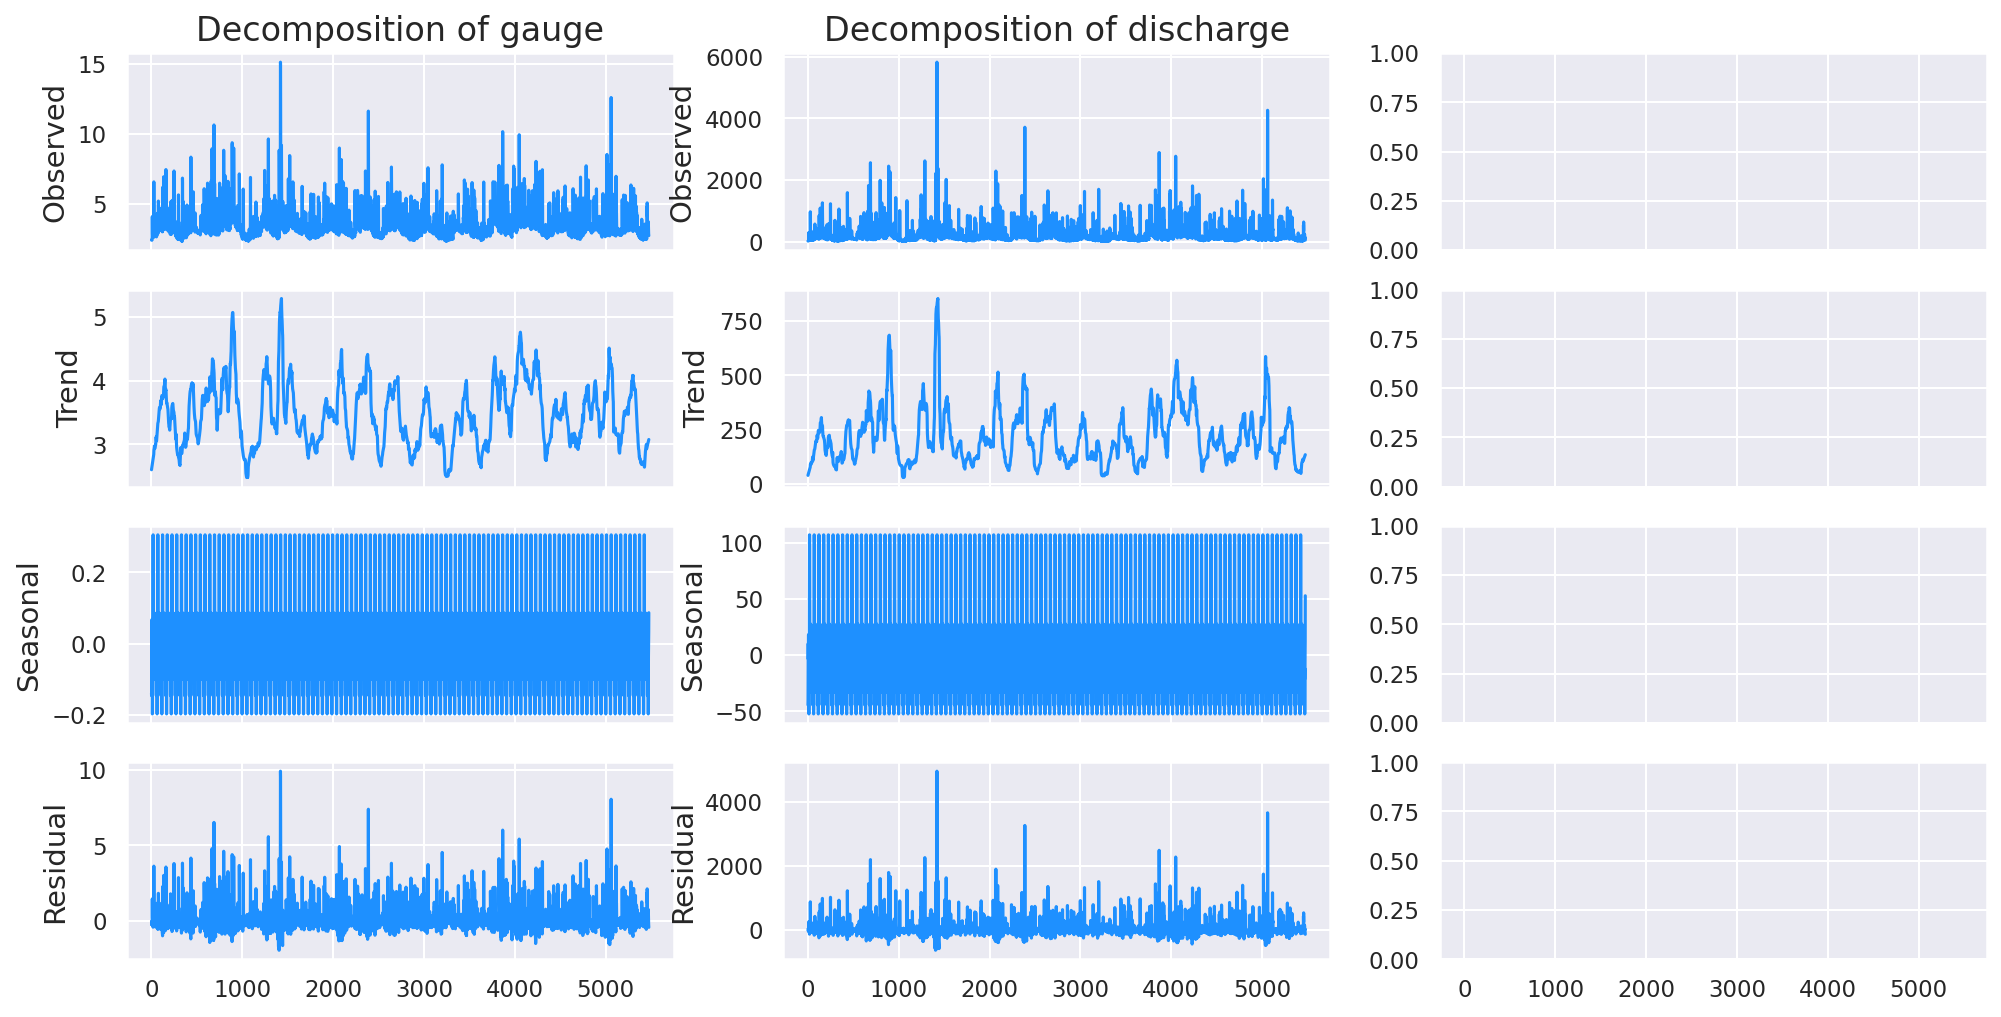

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=4, sharex=True, figsize=(16,8))

for i, column in enumerate(['gauge', 'discharge']):
    
    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [ ]:
# Exploratory Data Analysis

IndexError: ignored

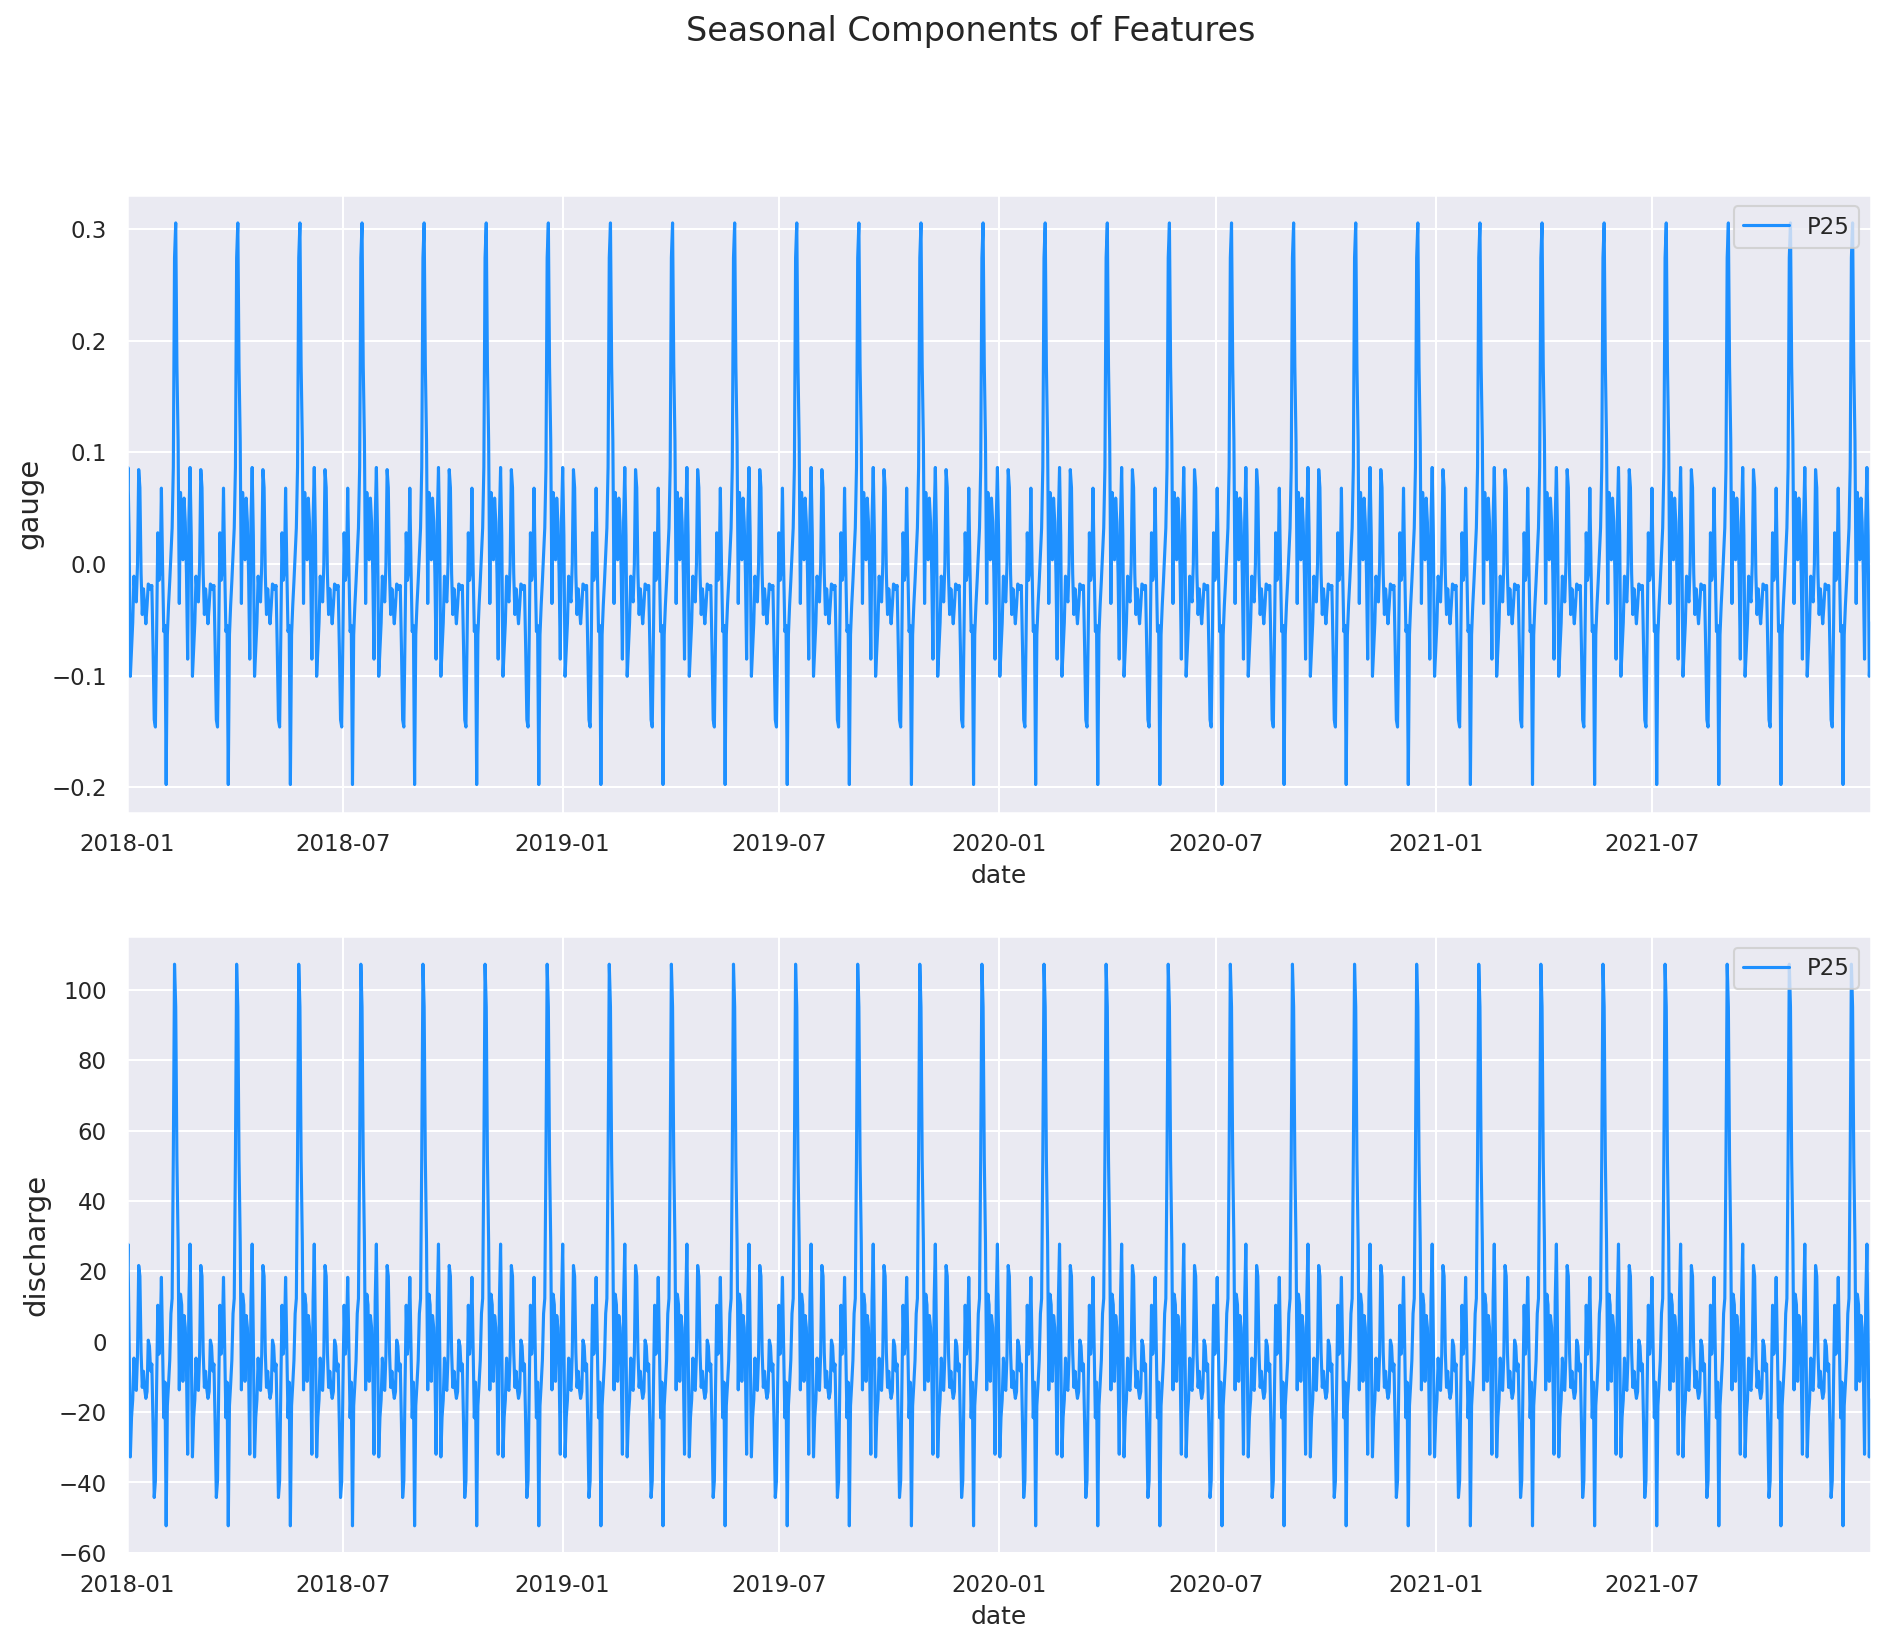

In [ ]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2018, 1, 1), date(2021, 12, 31)])
    
plt.tight_layout()
plt.show()

In [ ]:
# conclusion:  Gauge/ discharge reaches its MAXIMUM Februrary/April/mid-july/mid-Sep/.

In [ ]:
corrmat = df[core_columns].corr()
corrmat

,gauge,discharge,rainfall_ft
gauge,1.000000,0.964503,0.519915
discharge,0.964503,1.000000,0.502007
rainfall_ft,0.519915,0.502007,1.000000


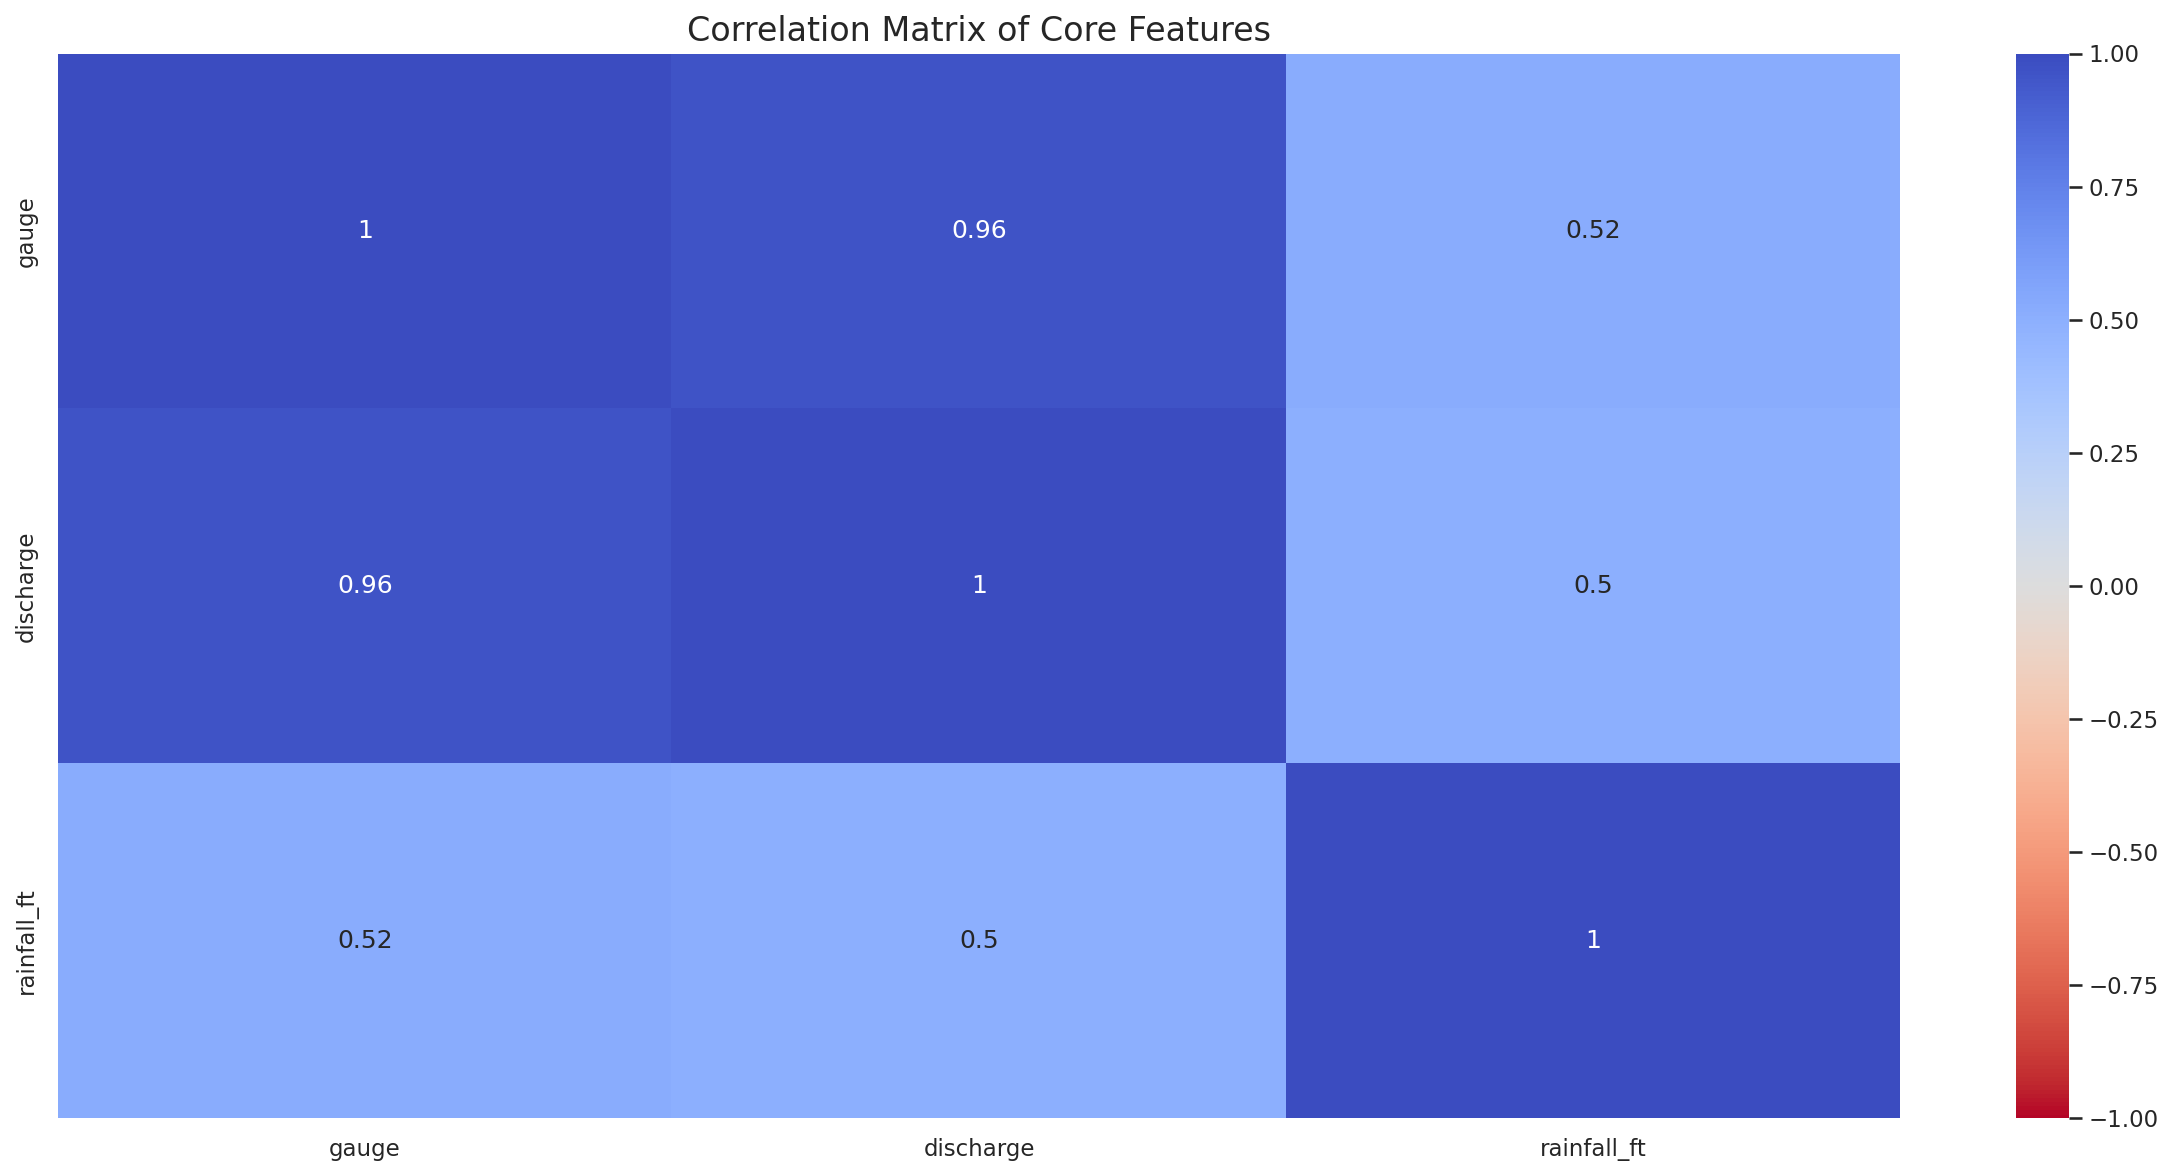

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r')
ax.set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'gauge',         
    'discharge',
    'rainfall_ft'
]

plt.tight_layout()
plt.show()

In [ ]:
#Modelling

In [8]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['gauge']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [9]:
train_size = int(0.90 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'gauge']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

4929 548


In [10]:
import prophet

In [11]:
import cmdstanpy
cmdstanpy.install_cmdstan()
cmdstanpy.install_cmdstan(compiler=True) # only valid on Windows

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmpg6_369l0
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0
Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
CmdStan version 2.31.0 already installed


True

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

#from fbprophet import Prophet
from prophet import Prophet

# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print( 'RMSE: {}'.format(score_rmse))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcnftw2x9/9yrcgwes.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcnftw2x9/9jfaz8vr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90587', 'data', 'file=/tmp/tmpcnftw2x9/9yrcgwes.json', 'init=/tmp/tmpcnftw2x9/9jfaz8vr.json', 'output', 'file=/tmp/tmpcnftw2x9/prophet_modela7alfcmr/prophet_model-20221207144220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1.0646220873743804


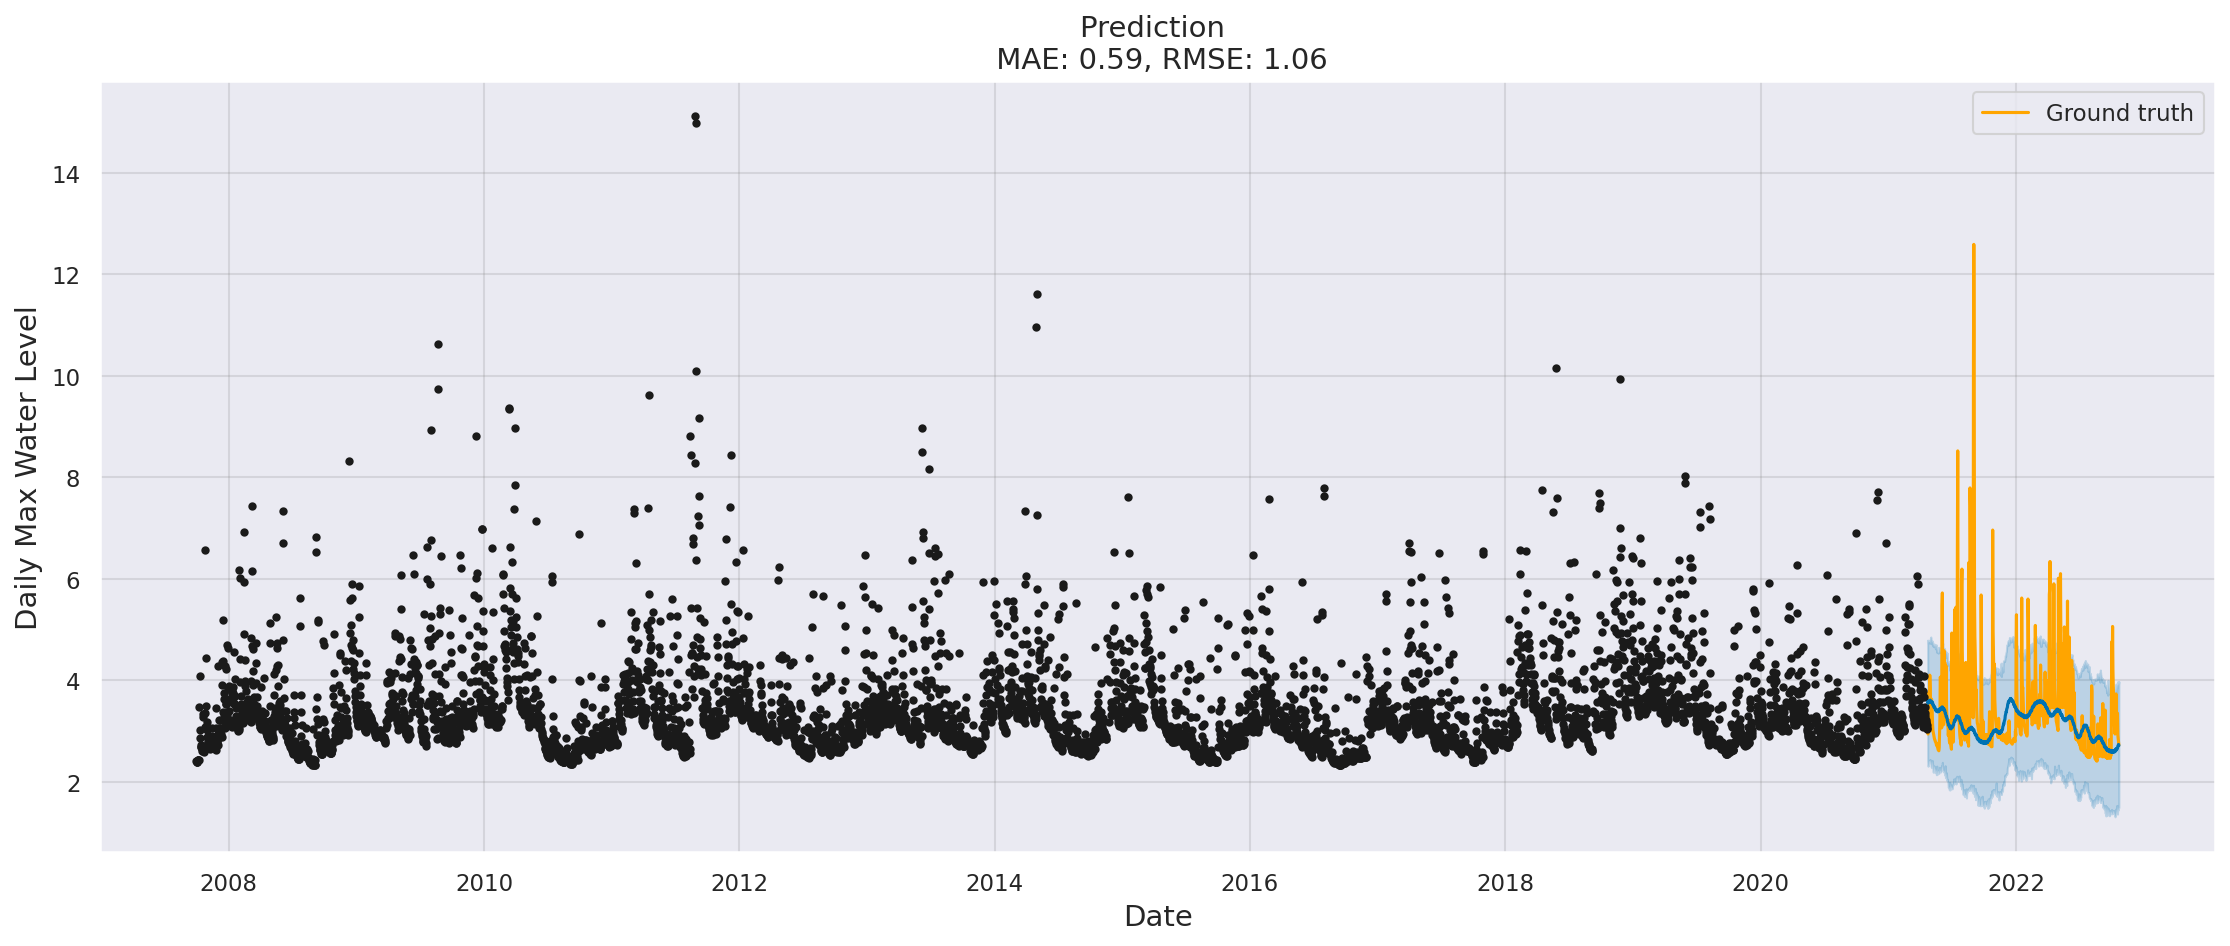

In [13]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite
model.plot(y_pred, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Daily Max Water Level', fontsize=14)

plt.show()

In [ ]:
#AUTO Arima Shifra will work on it 

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

ModuleNotFoundError: ignored

In [14]:
#lstm

In [15]:
from sklearn.preprocessing import MinMaxScaler

data = df.filter(['gauge'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)
scaled_data[:10]

array([[-0.99375   ],
       [-0.99453125],
       [-0.99453125],
       [-0.99453125],
       [-0.9921875 ],
       [-0.99140625],
       [-0.99140625],
       [-0.99140625],
       [-0.909375  ],
       [-0.8625    ]])

In [16]:
# Defines the rolling window
look_back = 2
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

4925 548


In [17]:
x_train.shape

(4925, 1, 2)

In [18]:
import keras.applications 
from tensorflow.keras.applications import resnet

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
4925/4925 [==============================] - 26s 4ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 2/5
4925/4925 [==============================] - 18s 4ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 3/5
4925/4925 [==============================] - 19s 4ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/5
4925/4925 [==============================] - 18s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 5/5
4925/4925 [==============================] - 18s 4ms/step - loss: 0.0037 - val_loss: 0.0033
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
        

In [20]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print('RMSE: {}'.format(score_rmse))

18/18 [==============================] - 0s 2ms/step
RMSE: 0.7396140176405754


In [22]:
from sklearn.metrics import r2_score
R_squared = r2_score(y_test[0], test_predict[:,0])

In [23]:
R_squared

0.4901442726766104

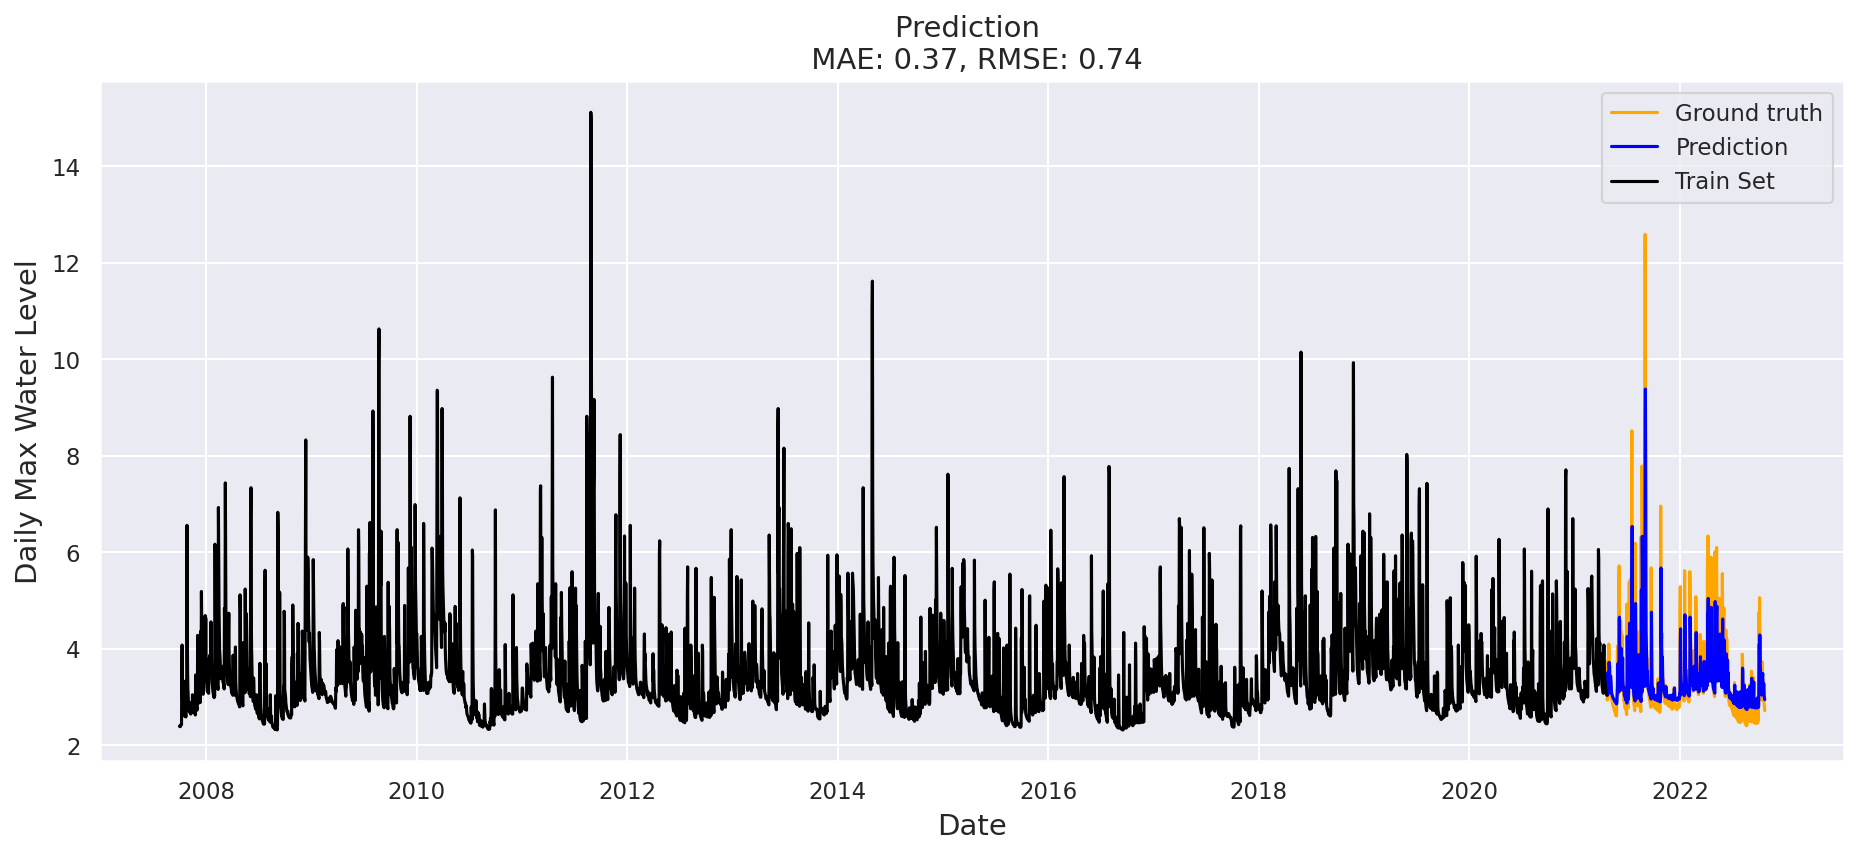

In [21]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='blue', label='Prediction') #navajowhite
sns.lineplot(x=x_train_ticks, y=y_train, ax=ax,  color='black',label='Train Set') #navajowhite


ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Daily Max Water Level', fontsize=14)

plt.show()

In [ ]:
# xgboost using discharge and rainfall 

In [ ]:
df3 = df[['date','gauge','discharge','rainfall_ft']]

In [ ]:
df3.set_index('date', inplace=True)

In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [ ]:
split_date = '2021-4-22'

In [ ]:
train, test = split_data(df3, split_date)

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_year_lag'] = df['gauge'].shift(365)
    df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()
    df['discharge_24_hrs_lag'] = df['discharge'].shift(1)
    df['discharge_24_hrs_mean'] = df['discharge'].rolling(window = 1).mean()
    df['discharge_24_hrs_std'] = df['discharge'].rolling(window = 1).std()
    df['discharge_24_hrs_max'] = df['discharge'].rolling(window = 1).max()
    df['discharge_24_hrs_min'] = df['discharge'].rolling(window = 1).min()
    df['discharge_week_lag'] = df['discharge'].shift(7)
    df['discharge_week_mean'] = df['discharge'].rolling(window = 7).mean()
    df['discharge_week_std'] = df['discharge'].rolling(window = 7).std()
    df['discharge_week_max'] = df['discharge'].rolling(window = 7).max()
    df['discharge_week_min'] = df['discharge'].rolling(window = 7).min()
    df['discharge_year_lag'] = df['discharge'].shift(365)
    df['discharge_year_mean'] = df['discharge'].rolling(window = 365).mean()
    df['discharge_year_std'] = df['discharge'].rolling(window = 365).std()
    df['discharge_year_max'] = df['discharge'].rolling(window = 365).max()
    df['discharge_year_min'] = df['discharge'].rolling(window = 365).min()
    df['rainfall_24_hrs_lag'] = df['rainfall_ft'].shift(1)
    df['rainfall_24_hrs_mean'] = df['rainfall_ft'].rolling(window = 1).mean()
    df['rainfall_24_hrs_std'] = df['rainfall_ft'].rolling(window = 1).std()
    df['rainfall_24_hrs_max'] = df['rainfall_ft'].rolling(window = 1).max()
    df['rainfall_24_hrs_min'] = df['rainfall_ft'].rolling(window = 1).min()
    df['rainfall_week_lag'] = df['rainfall_ft'].shift(7)
    df['rainfall_week_mean'] = df['rainfall_ft'].rolling(window = 7).mean()
    df['rainfall_week_std'] = df['rainfall_ft'].rolling(window = 7).std()
    df['rainfall_week_max'] = df['rainfall_ft'].rolling(window = 7).max()
    df['rainfall_week_min'] = df['rainfall_ft'].rolling(window = 7).min()
    df['rainfall_year_lag'] = df['rainfall_ft'].shift(365)
    df['rainfall_year_mean'] = df['rainfall_ft'].rolling(window = 365).mean()
    df['rainfall_year_std'] = df['rainfall_ft'].rolling(window = 365).std()
    df['rainfall_year_max'] = df['rainfall_ft'].rolling(window = 365).max()
    df['rainfall_year_min'] = df['rainfall_ft'].rolling(window = 365).min()


    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'  , 'gauge_24_hrs_lag' ,'gauge_week_lag','gauge_week_mean','gauge_week_std','gauge_week_max','gauge_week_min','gauge_year_lag','gauge_year_mean','gauge_year_std','gauge_year_max','gauge_year_min',
           'discharge_24_hrs_lag', 'discharge_24_hrs_mean', 'discharge_24_hrs_std', 'discharge_24_hrs_max','discharge_24_hrs_min','discharge_week_lag','discharge_week_mean','discharge_week_std','discharge_week_max','discharge_week_min',
            'discharge_year_lag','discharge_year_mean','discharge_year_std','discharge_year_max','discharge_year_min','rainfall_24_hrs_lag','rainfall_24_hrs_mean','rainfall_24_hrs_std','rainfall_week_max',
            'rainfall_week_min','rainfall_year_lag','rainfall_year_mean','rainfall_year_std','rainfall_year_max','rainfall_year_min']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 43), (4929,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=1000,
       verbose=False) 

[03:29:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [ ]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(base_data.index,base_data, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

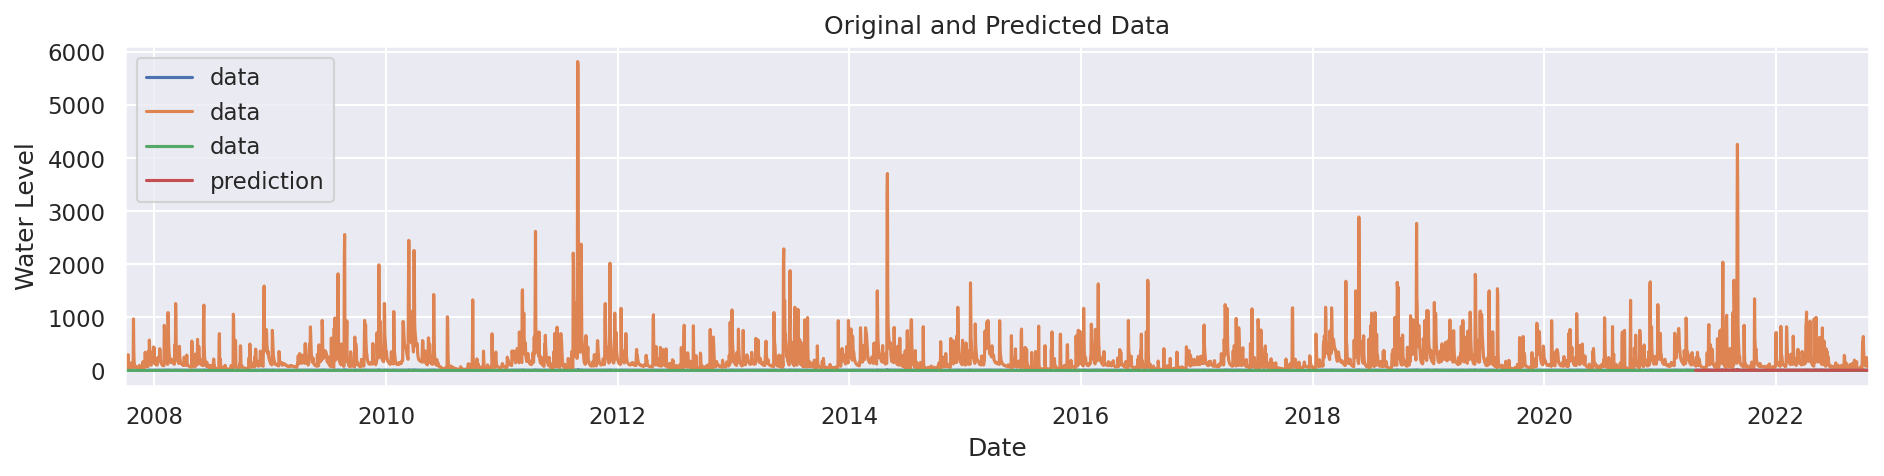

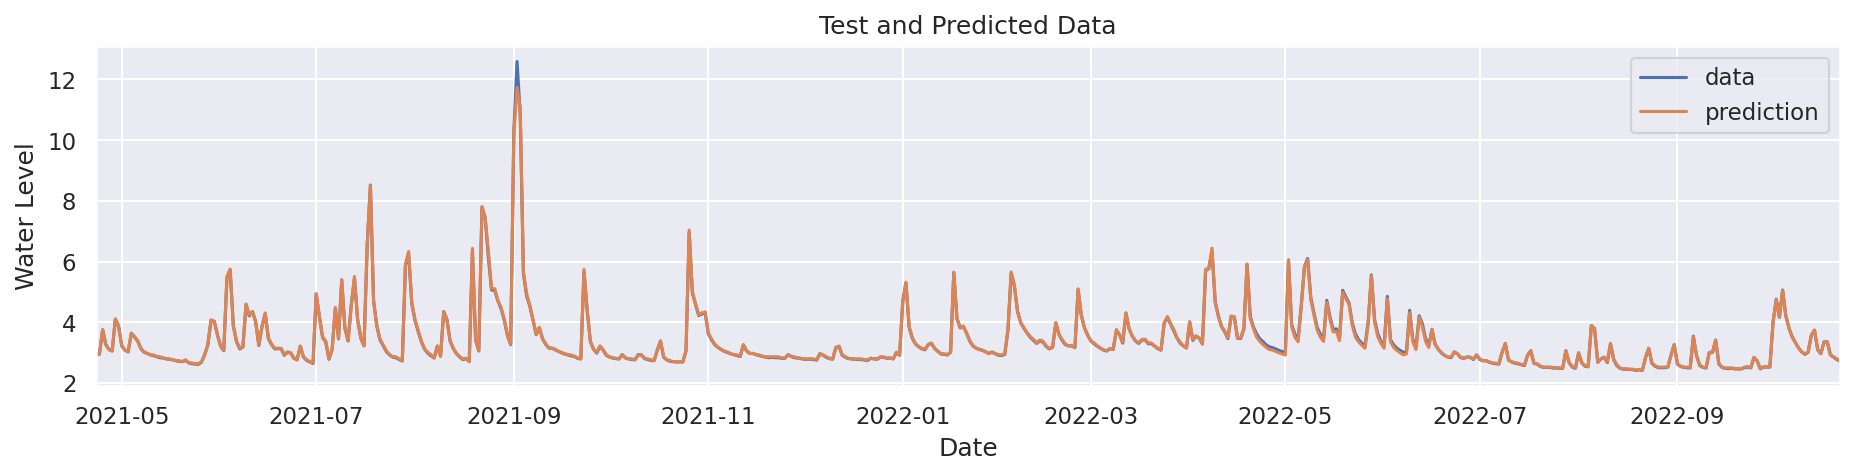

In [ ]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df3, df3.index[0].date(), df3.index[-1].date(),
                 'Original and Predicted Data')
plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')
plt.legend()

plt.show()

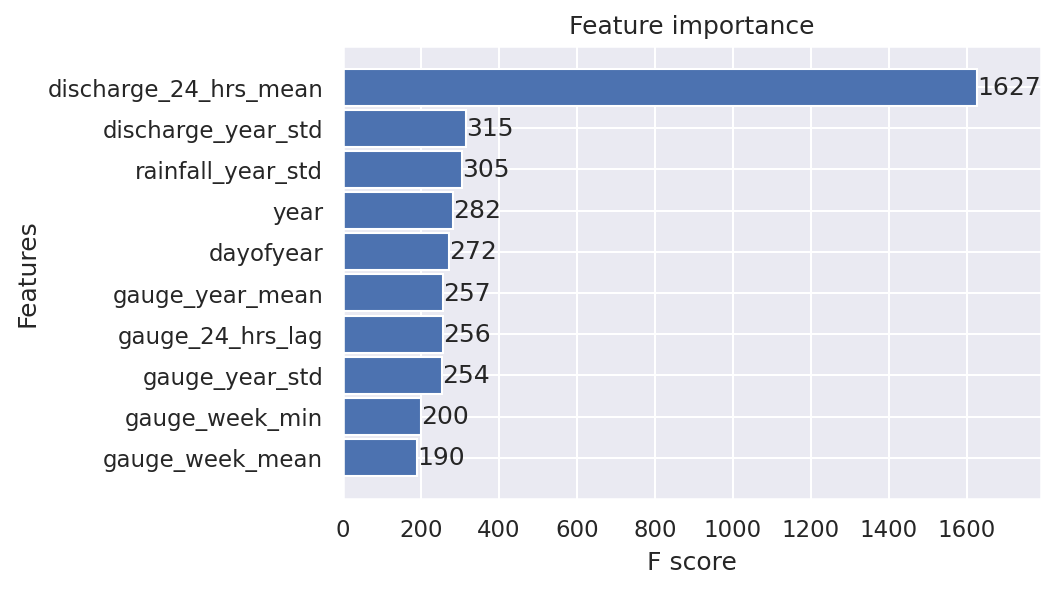

In [ ]:
xgb.plot_importance(reg, height=0.9,max_num_features = 10)

In [ ]:
mean_squared_error(y_test,X_test_pred)

0.0025008658618693733

In [ ]:
mean_absolute_error(y_test,X_test_pred)

0.023394028026692194

In [ ]:
# TOP 5 GAUGE AND DISCHARGE

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofmonth'] = df['date'].dt.day
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    df['gauge_month_lag'] = df['gauge'].shift(30)
    df['gauge_month_std'] = df['gauge'].rolling(window = 30).std()
    df['gauge_month_min'] = df['gauge'].rolling(window = 30).min()
    df['gauge_month_mean'] = df['gauge'].rolling(window = 30).mean()
    df['gauge_month_max'] = df['gauge'].rolling(window = 30).max()
    df['gauge_year_lag'] = df['gauge'].shift(365)
    df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()
    df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    
    X = df[['dayofmonth' , 
            'gauge_24_hrs_lag',
            'gauge_week_lag',
            'gauge_week_std',
            'gauge_week_min',
            'gauge_week_max',
            'gauge_week_mean',
            'gauge_month_lag',
            'gauge_month_std',
            'gauge_month_min', 
            'gauge_month_mean',
            'gauge_month_max',
            'gauge_year_lag',
            'gauge_year_mean',
            'gauge_year_std',
            'gauge_year_min',
            'gauge_year_max']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
# XGBOOST

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
df_xgboost = df[['date','gauge']]

In [ ]:
df_xgboost.set_index('date', inplace=True)

In [ ]:
df_xgboost

,gauge
date,
2007-10-01,2.40
2007-10-02,2.39
2007-10-03,2.39
2007-10-04,2.39
2007-10-05,2.42
...,...
2022-10-18,3.35
2022-10-19,2.92
2022-10-20,2.85


In [ ]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

In [ ]:
split_date = '2021-4-22'

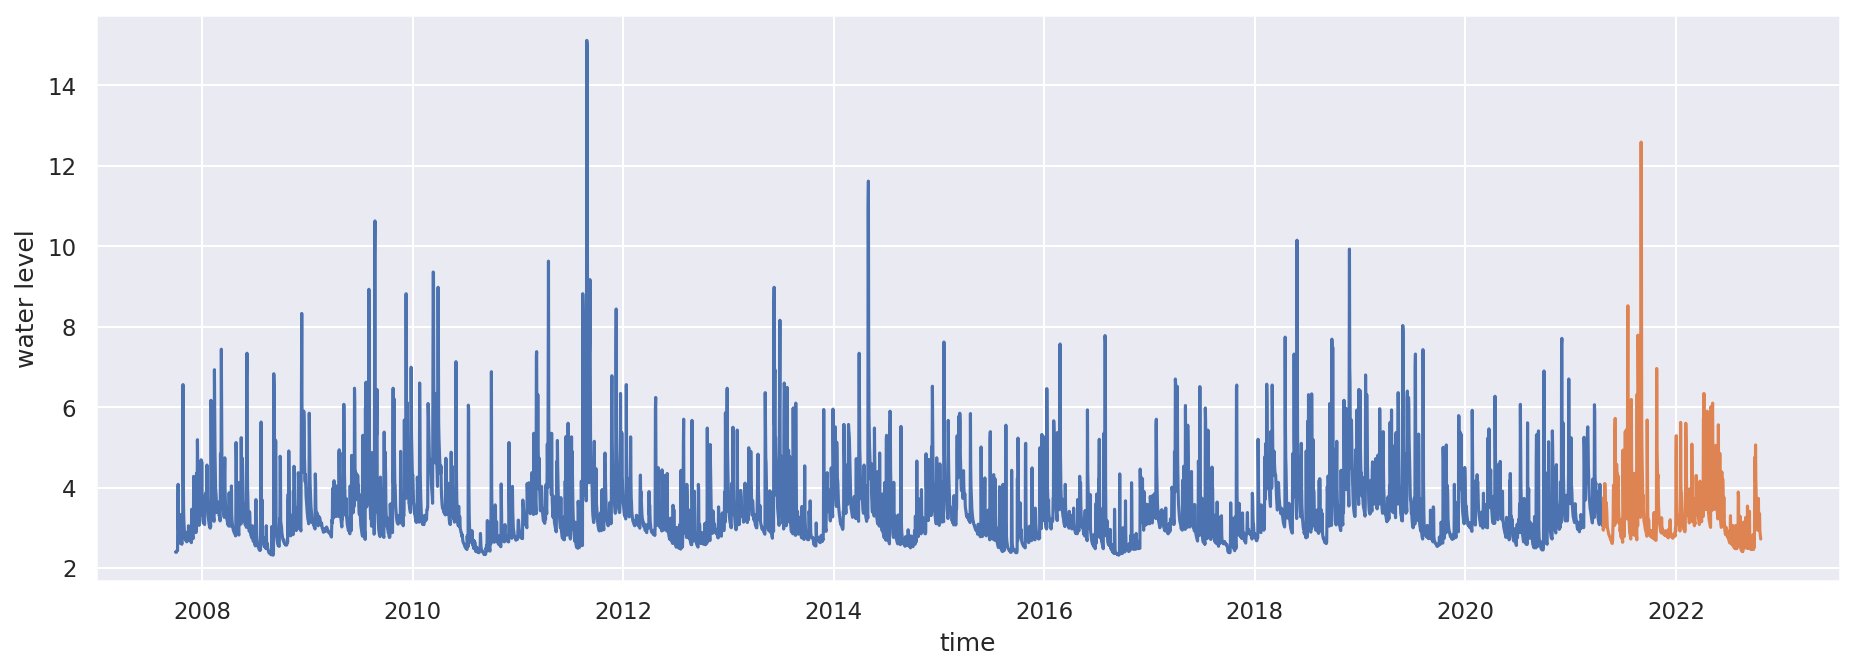

In [ ]:
train, test = split_data(df_xgboost, split_date)

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('water level')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [ ]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [ ]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 7), (4929,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=1000,
        #stop if 1000 consequent rounds without decrease of error
        verbose=False) 
# Change verbose to True if you want to see it train

[17:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

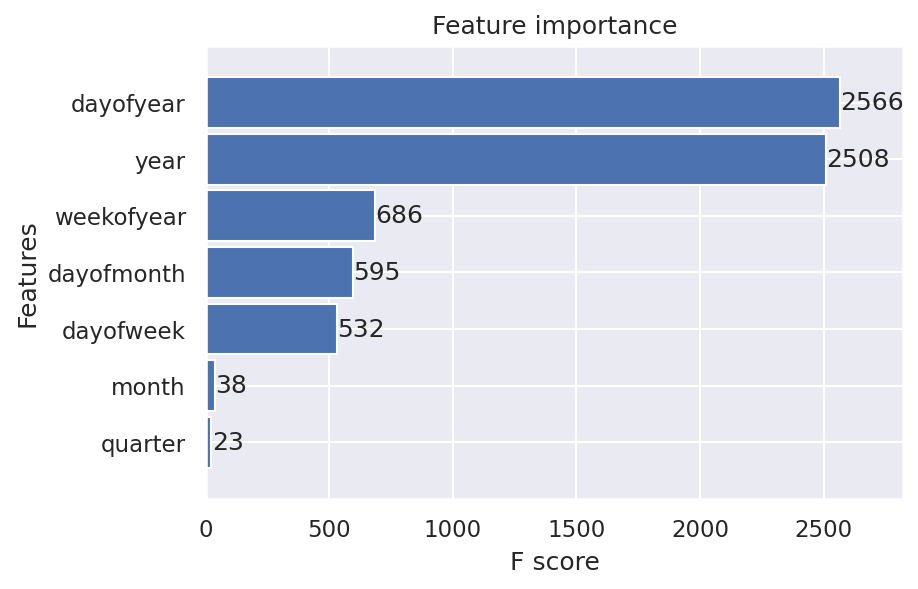

In [ ]:
xgb.plot_importance(reg, height=0.9)

In [ ]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(df_xgboost.index,df_xgboost, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

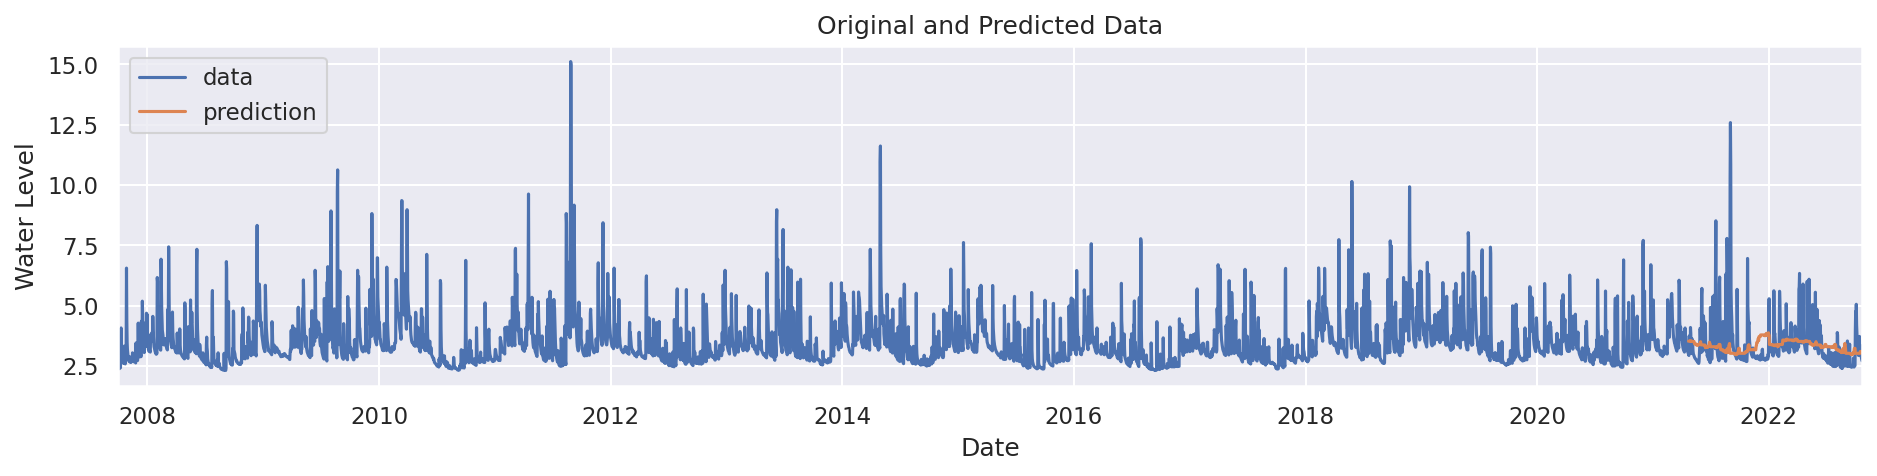

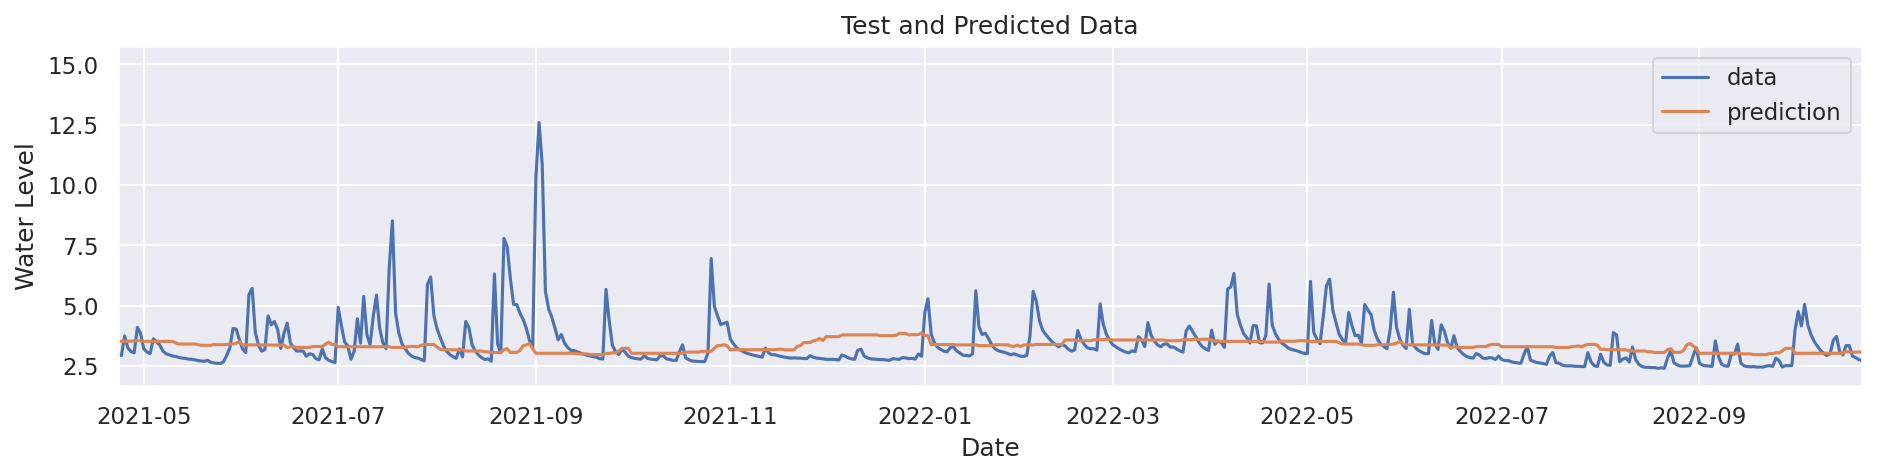

In [ ]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df_xgboost, df_xgboost.index[0].date(), df_xgboost.index[-1].date(),
                 'Original and Predicted Data')
plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')
plt.legend()

plt.show()

In [ ]:
mean_squared_error(y_test,X_test_pred)

1.1142516077739246

In [ ]:
mean_absolute_error(y_test,X_test_pred)

0.6310206409962507

In [ ]:
model = xgb.XGBRegressor(objective = 'reg:squarederror',
                         eval_metric='mae',
                         learning_rate = 0.01,
                         min_split_loss = 2000,  # gamma
                         reg_lambda = 100,  # lambda
                         max_depth = 8,
                         n_estimators = 300)

eval_set = [(X_train, y_train), (X_test, X_test_pred )] 
model.fit(X_train, y_train, eval_metric="mae", eval_set=eval_set, verbose=True, early_stopping_rounds=10)

[0]	validation_0-mae:2.94312	validation_1-mae:2.79779
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 10 rounds.
[1]	validation_0-mae:2.91425	validation_1-mae:2.76892
[2]	validation_0-mae:2.88565	validation_1-mae:2.74034
[3]	validation_0-mae:2.85734	validation_1-mae:2.71202
[4]	validation_0-mae:2.82932	validation_1-mae:2.68398
[5]	validation_0-mae:2.80155	validation_1-mae:2.65623
[6]	validation_0-mae:2.77405	validation_1-mae:2.62873
[7]	validation_0-mae:2.74685	validation_1-mae:2.60151
[8]	validation_0-mae:2.7199	validation_1-mae:2.57457
[9]	validation_0-mae:2.69321	validation_1-mae:2.54787
[10]	validation_0-mae:2.66678	validation_1-mae:2.52146
[11]	validation_0-mae:2.64062	validation_1-mae:2.4953
[12]	validation_0-mae:2.61471	validation_1-mae:2.46938
[13]	validation_0-mae:2.58906	validation_1-mae:2.44373
[14]	validation_0-mae:2.56366	validation_1-mae:2.41833
[15]	validation_0-mae:2.5385	v

XGBRegressor(eval_metric='mae', learning_rate=0.01, max_depth=8,
             min_split_loss=2000, n_estimators=300,
             objective='reg:squarederror', reg_lambda=100)

In [ ]:
#xgboost and add gauge rolling window

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_year_lag'] = df['gauge'].shift(365)
    df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()

    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear'  , 'gauge_24_hrs_lag' ,"gauge_24_hrs_mean"  ,"gauge_24_hrs_std",
           "gauge_24_hrs_max" ,"gauge_24_hrs_min",'gauge_week_lag','gauge_week_mean','gauge_week_std','gauge_week_max','gauge_week_min','gauge_year_lag','gauge_year_mean','gauge_year_std','gauge_year_max','gauge_year_min']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((5091, 22), (5091,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=1000,
       verbose=False) 

[01:16:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

In [ ]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Water Level')
    plt.plot(base_data.index,base_data, label='data')
    plt.plot(y_test.index,y_test, label='Groundtruth')
    plt.plot(X_test.index,X_test_pred, color = 'white',label='prediction',linestyle = '-.')
    
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

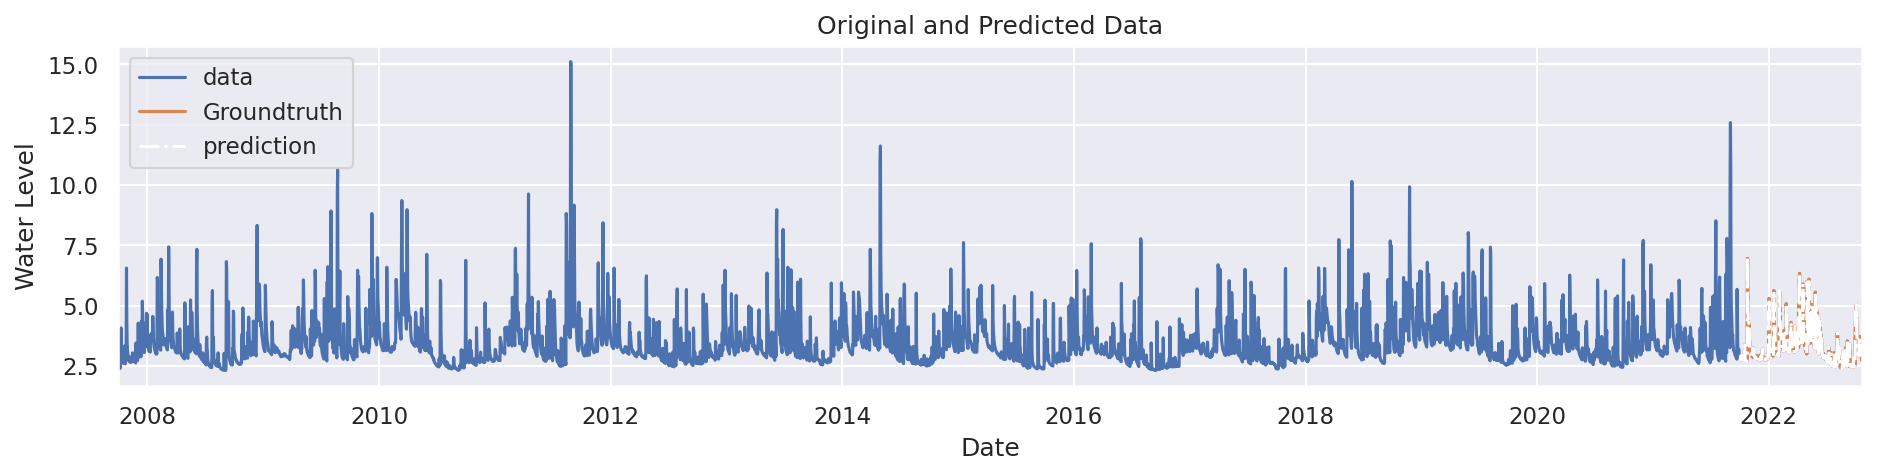

In [ ]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df_xgboost, df_xgboost.index[0].date(), df_xgboost.index[-1].date(),
                 'Original and Predicted Data')

plt.legend()

plt.show()

Text(0.5, 1.0, ' Forecast vs Actuals')

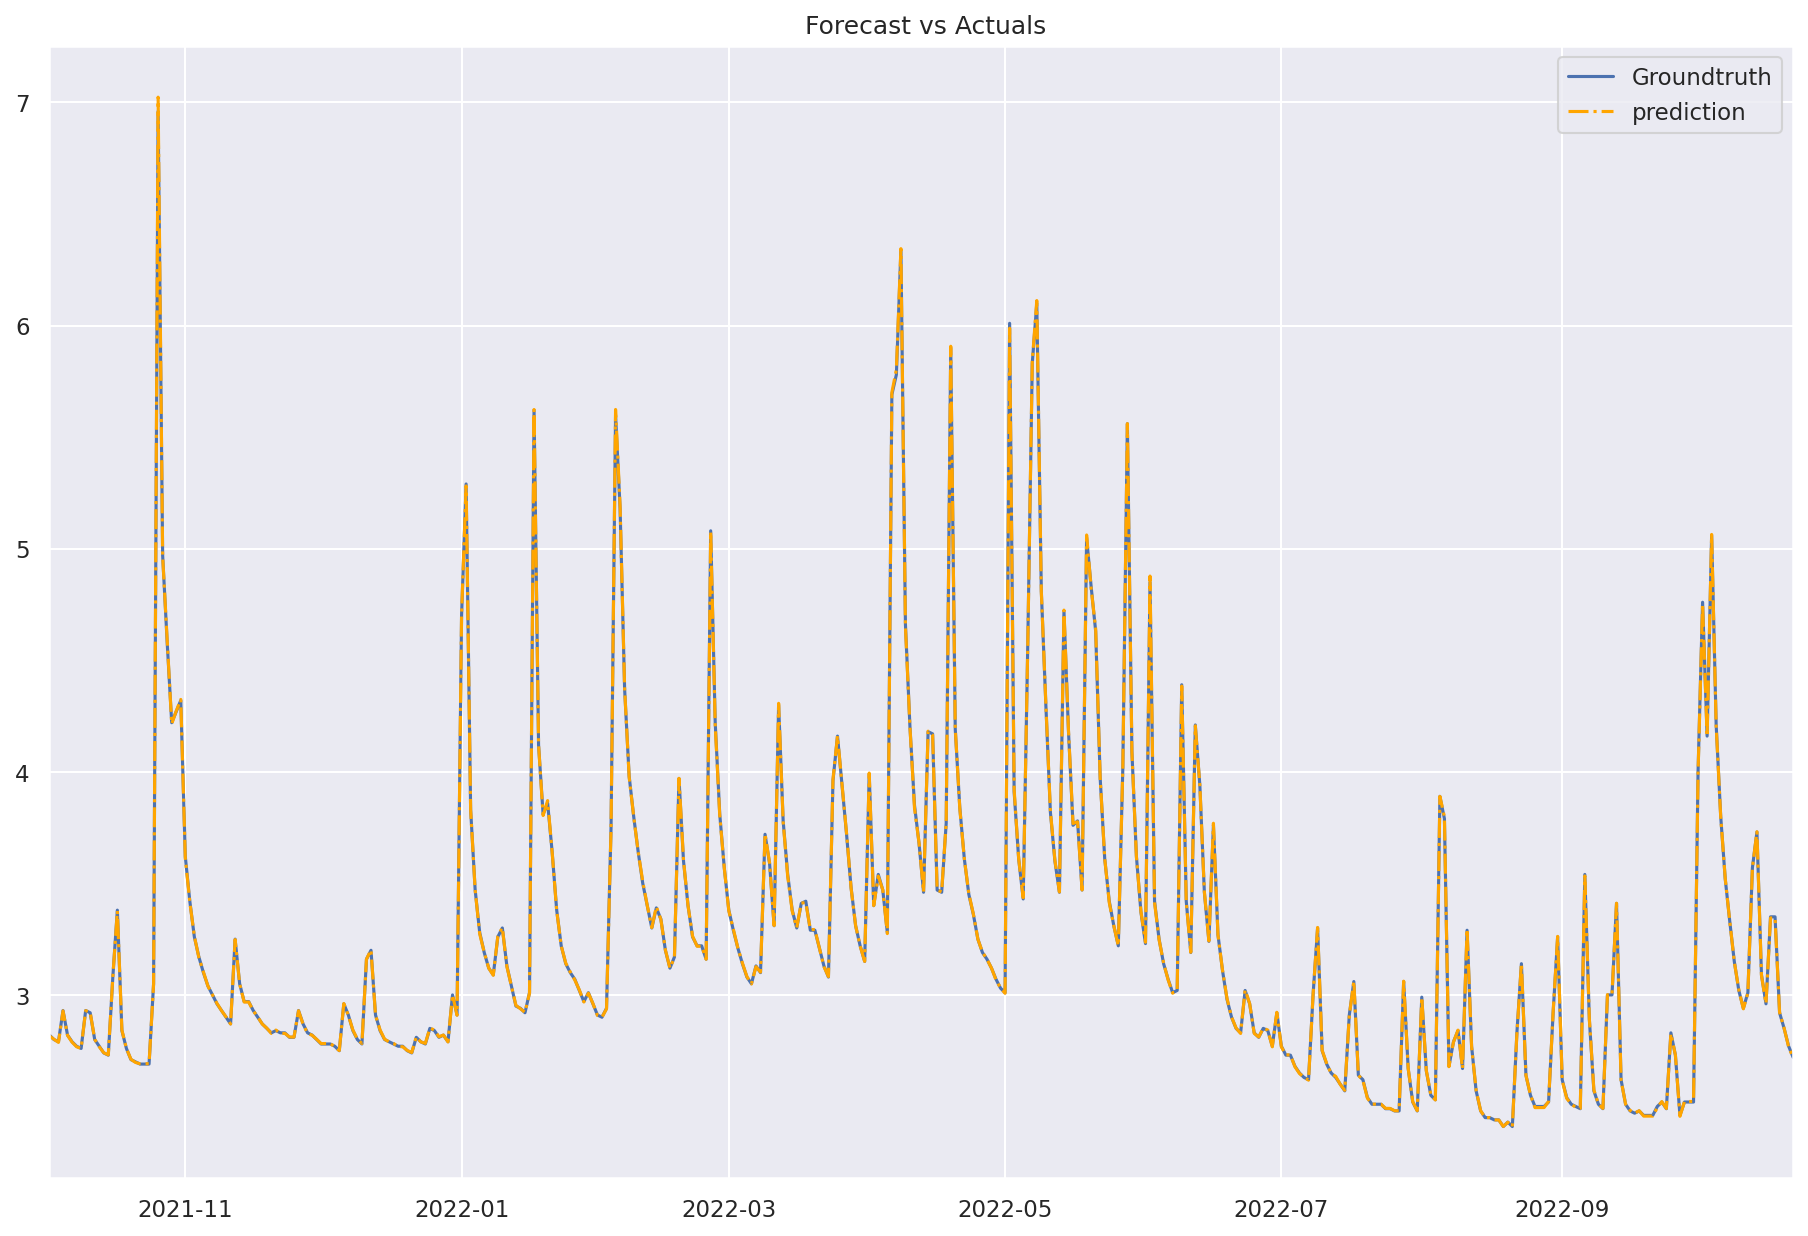

In [ ]:
  plt.figure(figsize=(15,10))
  plt.plot(y_test.index,y_test, label='Groundtruth', linestyle = '-')
  
  plt.plot(X_test.index,X_test_pred, color = 'orange',label='prediction', linestyle='dashdot')
  plt.legend()
  plt.xlim(left= y_test.index[0].date(), right = y_test.index[-1].date())
  plt.title(' Forecast vs Actuals')

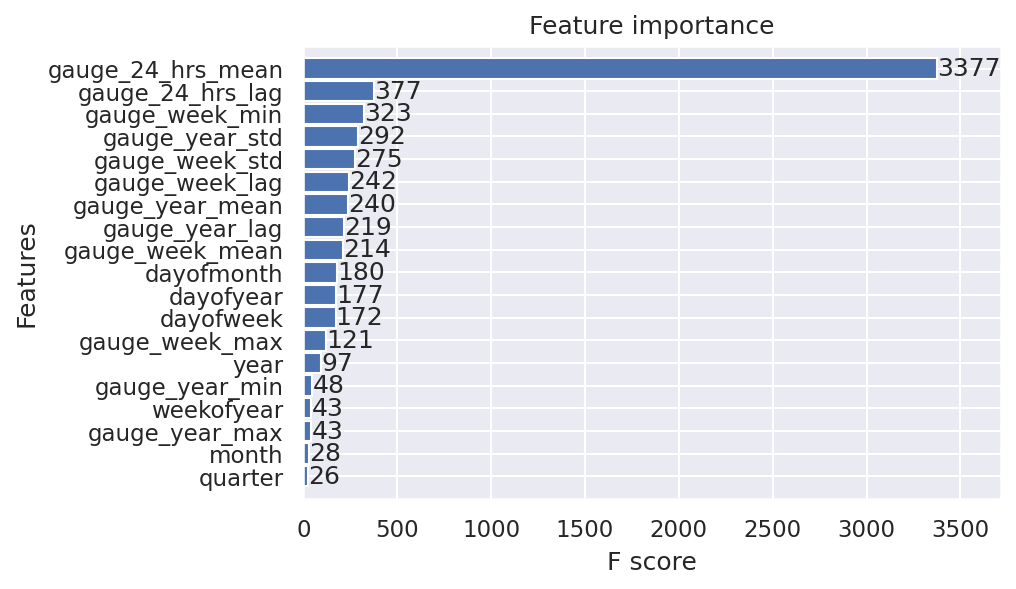

In [ ]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 20)

In [ ]:
mean_squared_error(y_test,X_test_pred)

2.871899086317036e-05

In [ ]:
mean_absolute_error(y_test,X_test_pred)

0.0029676787470288954

In [ ]:
# XGBOOST WITH gauge weekly, monthly, yearly important features

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofmonth'] = df['date'].dt.day
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    df['gauge_month_lag'] = df['gauge'].shift(30)
    df['gauge_month_std'] = df['gauge'].rolling(window = 30).std()
    df['gauge_month_min'] = df['gauge'].rolling(window = 30).min()
    df['gauge_month_mean'] = df['gauge'].rolling(window = 30).mean()
    df['gauge_month_max'] = df['gauge'].rolling(window = 30).max()
    df['gauge_year_lag'] = df['gauge'].shift(365)
    df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    df['gauge_year_min'] = df['gauge'].rolling(window = 365).min()
    df['gauge_year_max'] = df['gauge'].rolling(window = 365).max()
    
    X = df[['dayofmonth' , 
            'gauge_24_hrs_lag',
            'gauge_week_lag',
            'gauge_week_std',
            'gauge_week_min',
            'gauge_week_max',
            'gauge_week_mean',
            'gauge_month_lag',
            'gauge_month_std',
            'gauge_month_min', 
            'gauge_month_mean',
            'gauge_month_max',
            'gauge_year_lag',
            'gauge_year_mean',
            'gauge_year_std',
            'gauge_year_min',
            'gauge_year_max']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 17), (4929,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=1000,
       verbose=False) # Change verbose to True if you want to see it train

[21:25:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

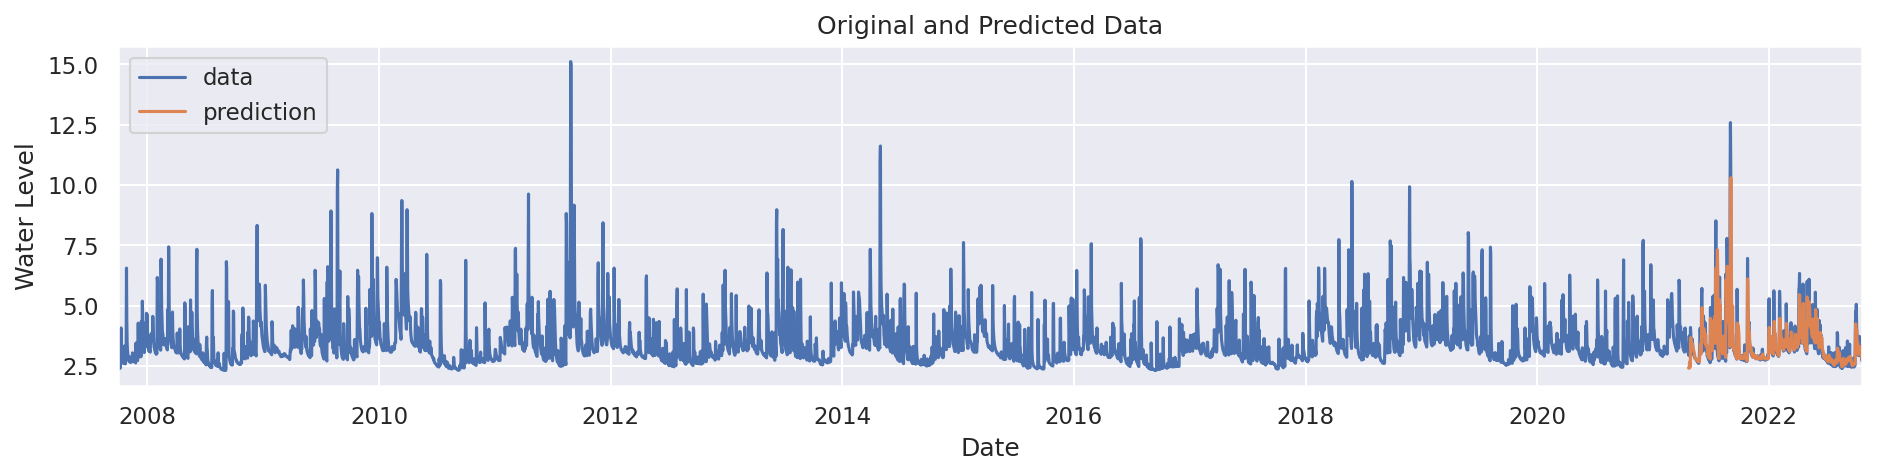

In [ ]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df_xgboost, df_xgboost.index[0].date(), df_xgboost.index[-1].date(),
                 'Original and Predicted Data')

plt.legend()

plt.show()

Text(0.5, 1.0, ' Forecast vs Actuals')

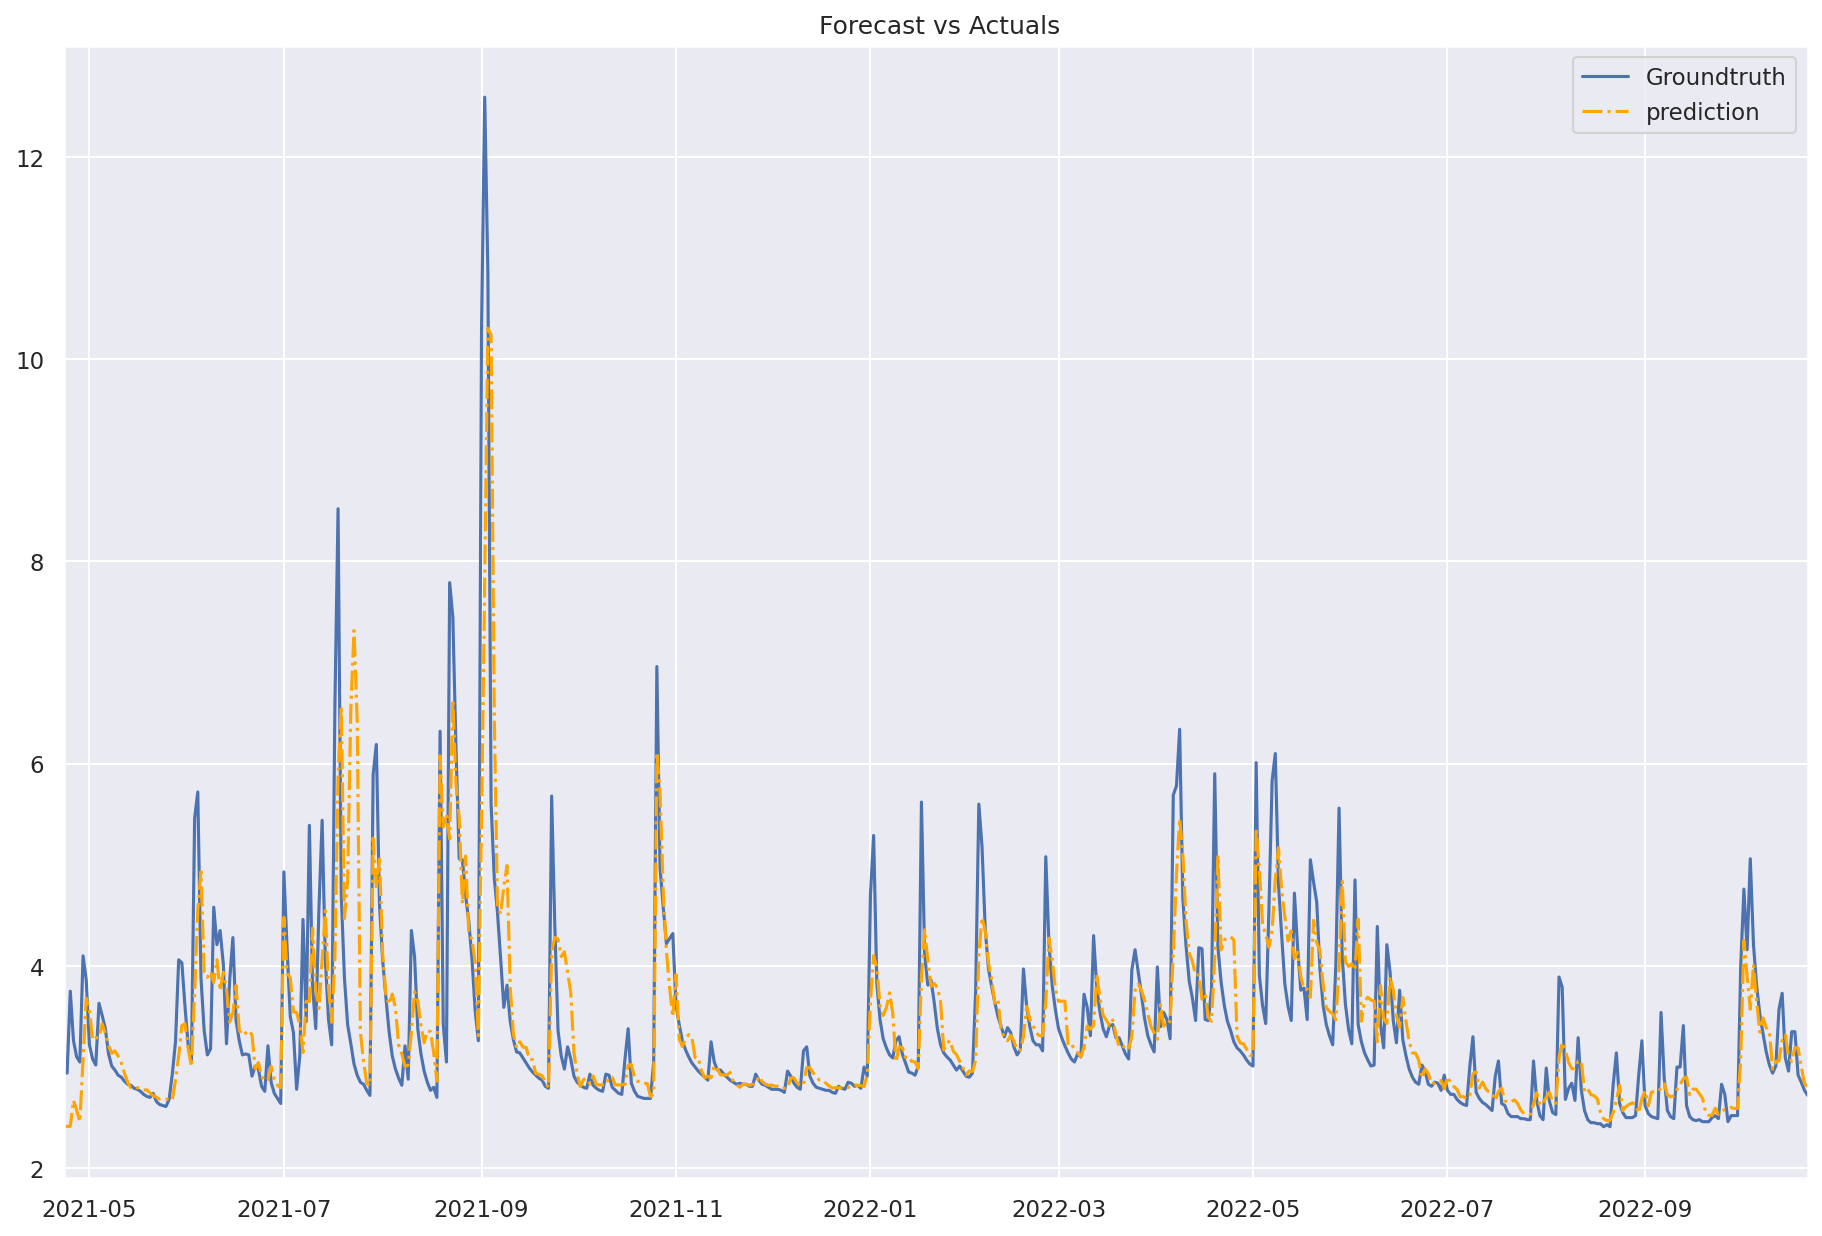

In [ ]:
  plt.figure(figsize=(15,10))
  plt.plot(y_test.index,y_test, label='Groundtruth', linestyle = '-')
  
  plt.plot(X_test.index,X_test_pred, color = 'orange',label='prediction', linestyle='dashdot')
  plt.legend()
  plt.xlim(left= y_test.index[0].date(), right = y_test.index[-1].date())
  plt.title(' Forecast vs Actuals')

In [ ]:
mean_squared_error(y_test,X_test_pred)

0.46546369344097244

In [ ]:
mean_absolute_error(y_test,X_test_pred)

0.36555330800314023

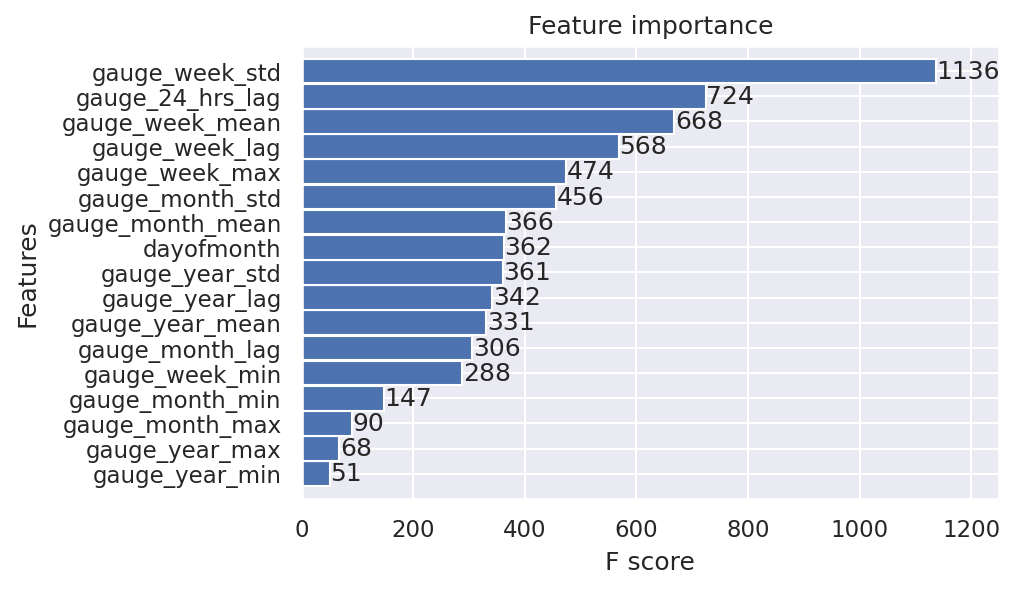

In [ ]:
_ = plot_importance(reg, height=0.98)

In [ ]:
# top 5 features

In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    #df['dayofmonth'] = df['date'].dt.day
    df['gauge_24_hrs_lag'] = df['gauge'].shift(1)
    #df['gauge_24_hrs_mean'] = df['gauge'].rolling(window = 1).mean()
    #df['gauge_24_hrs_std'] = df['gauge'].rolling(window = 1).std()
    #df['gauge_24_hrs_max'] = df['gauge'].rolling(window = 1).max()
    #df['gauge_24_hrs_min'] = df['gauge'].rolling(window = 1).min()
    df['gauge_week_lag'] = df['gauge'].shift(7)
    df['gauge_week_std'] = df['gauge'].rolling(window = 7).std()
    #df['gauge_week_min'] = df['gauge'].rolling(window = 7).min()
    df['gauge_week_max'] = df['gauge'].rolling(window = 7).max()
    df['gauge_week_mean'] = df['gauge'].rolling(window = 7).mean()
    #df['gauge_month_lag'] = df['gauge'].shift(30)
    df['gauge_month_std'] = df['gauge'].rolling(window = 30).std()
    #df['gauge_month_min'] = df['gauge'].rolling(window = 30).min()
    #df['gauge_month_mean'] = df['gauge'].rolling(window = 30).mean()
    #df['gauge_month_max'] = df['gauge'].rolling(window = 30).max()
    #df['gauge_year_lag'] = df['gauge'].shift(365)
    #df['gauge_year_mean'] = df['gauge'].rolling(window = 365).mean()
    df['gauge_year_std'] = df['gauge'].rolling(window = 365).std()
    #df['gauge_year_min'] = df['gauge'].rolling(window = 1).min()
    #df['gauge_year_max'] = df['gauge'].rolling(window = 1).max()
    
    X = df[[
            'gauge_24_hrs_lag',
            'gauge_week_lag',
            'gauge_week_std',
            'gauge_week_max',
            'gauge_week_mean',
            'gauge_month_std',
            'gauge_year_std']]
    if label:
        y = df[label]
        return X, y
    return X

In [ ]:
X_train, y_train = create_features(train), train['gauge']
X_test, y_test   = create_features(test), test['gauge']

X_train.shape, y_train.shape

((4929, 7), (4929,))

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_valid)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

[19:02:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

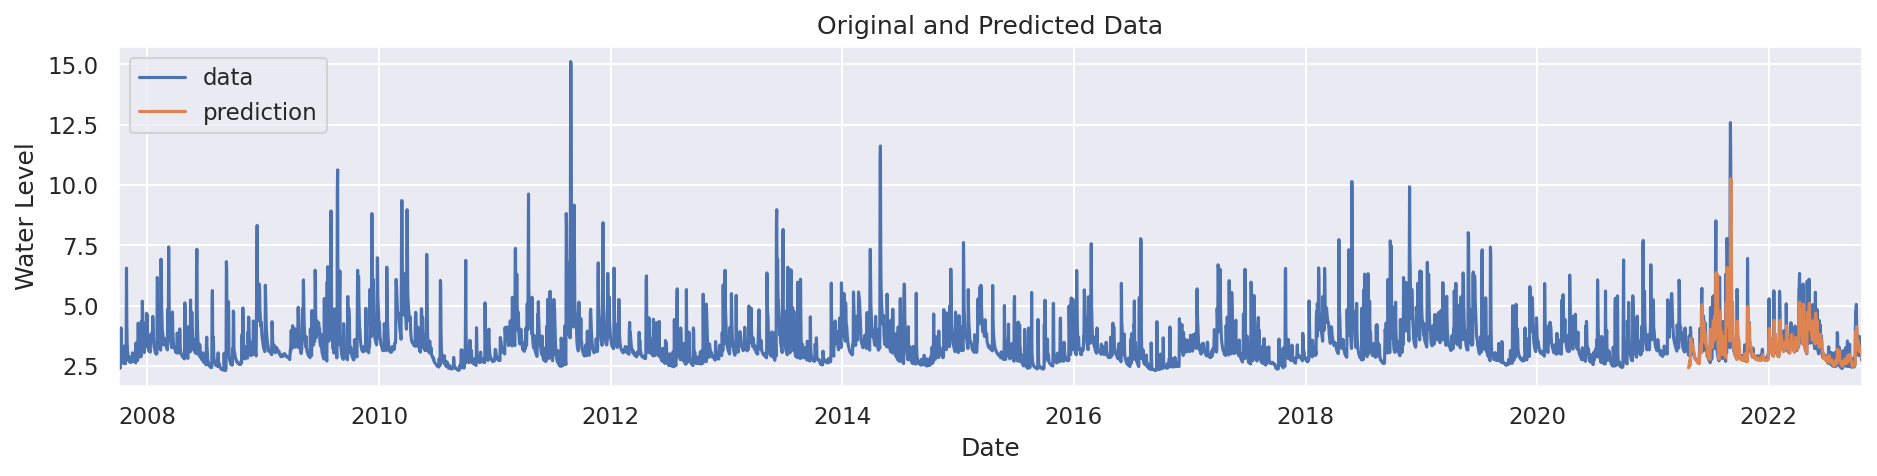

In [ ]:
X_test_pred = reg.predict(X_test)
    
plot_performance(df_xgboost, df_xgboost.index[0].date(), df_xgboost.index[-1].date(),
                 'Original and Predicted Data')

plt.legend()

plt.show()

Text(0.5, 1.0, ' Forecast vs Actuals')

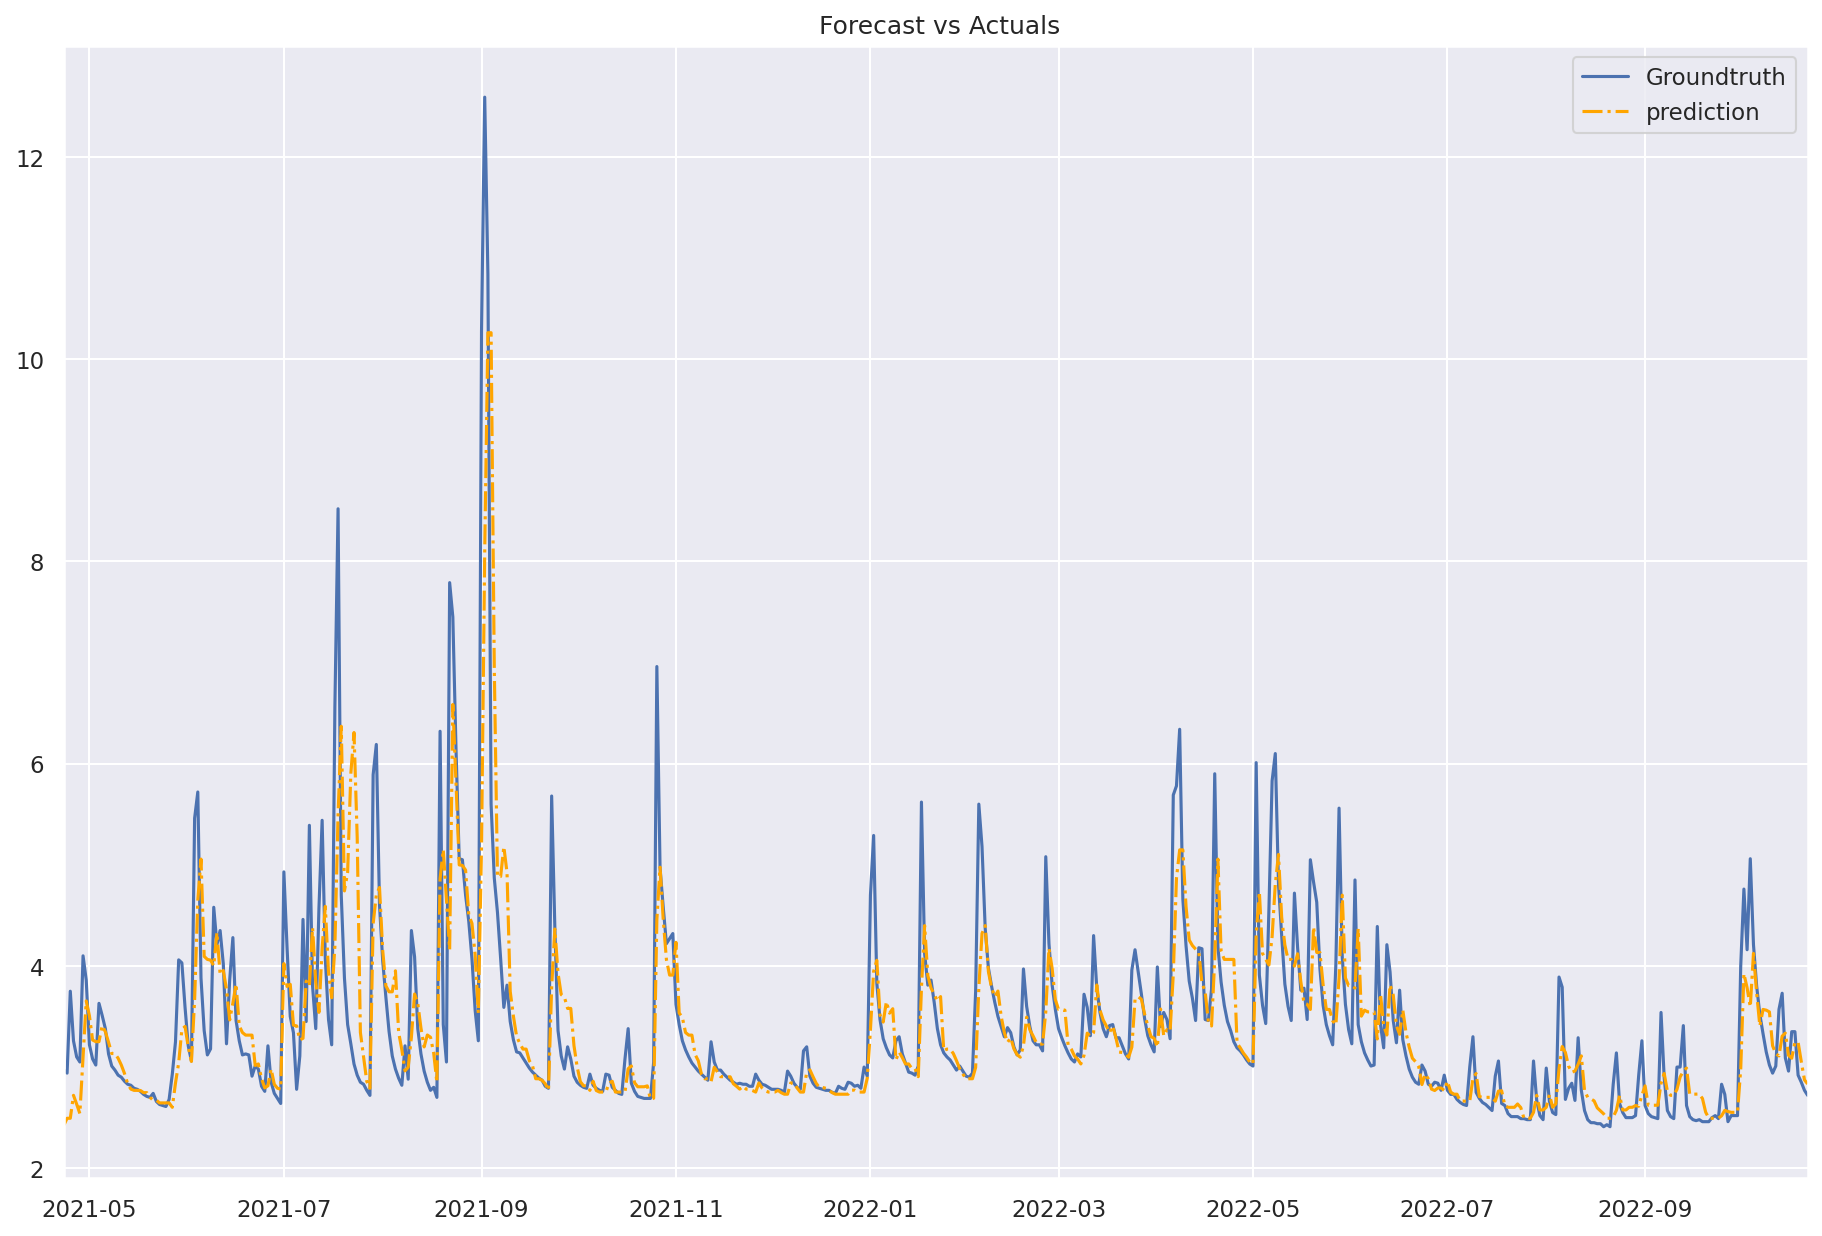

In [ ]:
  plt.figure(figsize=(15,10))
  plt.plot(y_test.index,y_test, label='Groundtruth', linestyle = '-')
  
  plt.plot(X_test.index,X_test_pred, color = 'orange',label='prediction', linestyle='dashdot')
  plt.legend()
  plt.xlim(left= y_test.index[0].date(), right = y_test.index[-1].date())
  plt.title(' Forecast vs Actuals')

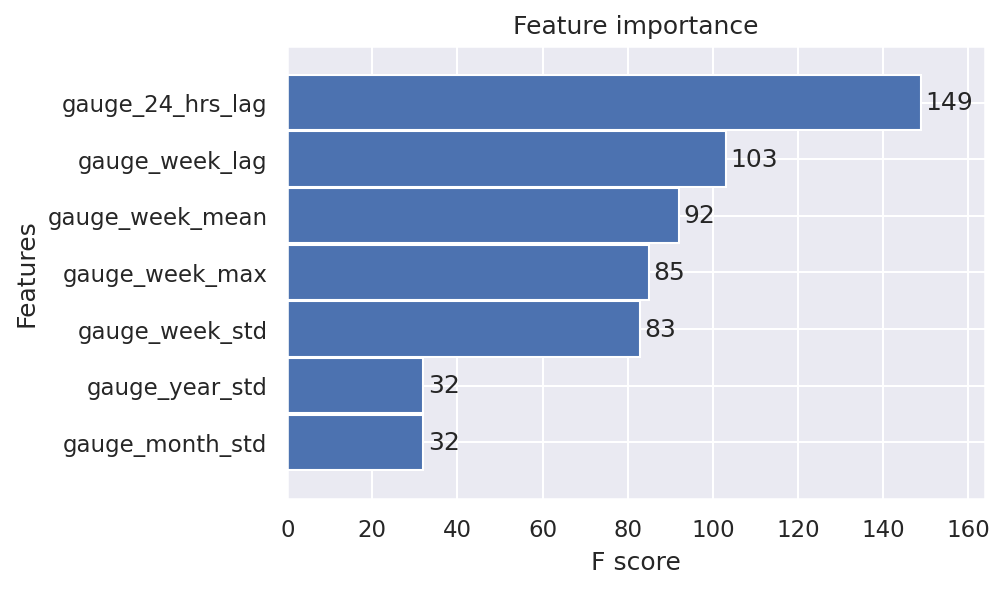

In [ ]:
_ = plot_importance(reg, height=0.98)

In [ ]:
mean_squared_error(y_test,X_test_pred)

0.0011259410260553977

In [ ]:
mean_absolute_error(y_test,X_test_pred)

0.0048564423783852145

In [ ]:
# https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost
# https://www.kaggle.com/code/sayedathar11/time-series-forecasting-xgboost-lags-and-rolling
# https://www.kaggle.com/code/adro99/xgboost-for-time-series-forecasting
# 

In [ ]:
# Forecast on test dataset

In [ ]:
# Holter:

In [ ]:
# set the span and the smoothing factor alpha

In [ ]:
# https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting
# pmarima

In [ ]:
# arima https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting